In [41]:
import pandas
import os
import sys
import itertools
import plotly
import numpy as np
import nibabel as ni
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
from nilearn import plotting
from nilearn.datasets import MNI152_FILE_PATH
from sklearn.cross_decomposition import CCA, PLSRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, calinski_harabasz_score, silhouette_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.base import clone
from statsmodels.sandbox.stats.multicomp import multipletests
from importlib import reload
sys.path.insert(0,'/Users/jacobv/git/data_driven_pathology/')
#sys.path.insert(0,'/Users/jakevogel/git/data_driven_pathology')
import vogel_basc as vb
import CrossDecomp as XD
sys.path.insert(0,'/home/users/jvogel/git/Hippocampus_AP_Axis/')
#import HAP_Utils as hap

In [2]:
%matplotlib inline

# Prepare Data

In [3]:
corrected_data = pandas.read_pickle('/Users/jacobv/Science/PLS_GXP/txfer/corrected_AHBA_data.pk')

In [4]:
sorders = []
datas = []
for sid,data in corrected_data.items():
    sorder = pandas.concat([pandas.Series([sid]*len(data)),
                           pandas.Series(data.index.values)],
                          axis=1)
    sorder.columns = ['subject','samp_id']
    sorders.append(sorder)
    datas.append(data)

sample_order = pandas.concat(sorders)
sample_order.index = range(len(sample_order))
bigdf = pandas.concat(datas)
bigdf.index=range(len(bigdf))

In [5]:
bigdf.shape

(3466, 15633)

In [6]:
wdir = '/Users/jacobv/Science/PLS_GXP/txfer/'
probes = pandas.read_csv(os.path.join(wdir,'Probes.csv'))
gdf = pandas.read_csv(os.path.join(wdir,'gxp_correlation_wholebrain_results_NEW.csv'))
gdfBD = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/txfer/MAIN_gcx_wholebrain_info_W_BRAIN_DIVISIONS.csv')


In [12]:
new_gdf = []
for subject in sample_order.subject.unique():
    sampids = sample_order[sample_order.subject==subject].samp_id.values+1
    #shared = set(gdf['sample']) & set(sampids)
    selection = gdf[(gdf.donor==int(subject)) &\
                    (gdf['sample'].isin(sampids))]
    new_gdf.append(selection)
old_gdf = pandas.DataFrame(gdf,copy=True)
gdf = pandas.concat(new_gdf)

In [13]:
new_gdfBD = []
for subject in sample_order.subject.unique():
    sampids = sample_order[sample_order.subject==subject].samp_id.values+1
    #shared = set(gdf['sample']) & set(sampids)
    selection = gdfBD[(gdfBD.donor==int(subject)) &\
                    (gdfBD['sample'].isin(sampids))]
    new_gdfBD.append(selection)
old_gdfBD = pandas.DataFrame(gdfBD,copy=True)
gdfBD = pandas.concat(new_gdfBD)

In [14]:
gdf.index = range(len(gdf.index))
gdfBD.index = range(len(gdfBD.index))

In [15]:
too_few = [x for x in gdf.structure_acronym.value_counts().index if gdf.structure_acronym.value_counts()[x] < 2]
gdf.loc[:,'new_structure_acronym'] = ['Other' if x in too_few else x for x in gdf.structure_acronym.values]

In [16]:
pcamod = PCA(n_components=100, random_state=123).fit(bigdf)
sum(pcamod.explained_variance_ratio_)

0.8460579522910671

In [17]:
pca_tfm = pandas.DataFrame(pcamod.transform(bigdf))

In [18]:
gdf.loc[:,'abs_mni_nlin_x'] = abs(gdf.mni_nlin_x.values)
full_y = gdf[['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]


# Leave one region out

In [21]:
clf_pca.score(Xtr,ytr)

0.5150288514163467

In [24]:
all(gdf.index == gdfBD.index)

True

In [25]:
all(bigdf.index == gdfBD.index)

True

In [50]:
pca_tfm.shape

(3466, 100)

In [48]:
ycols = ['mni_nlin_y', 'mni_nlin_z','abs_mni_nlin_x',]
loro = pandas.DataFrame()
for i,BD in enumerate(gdfBD.brain_divison.unique()):
    if not pandas.notnull(BD): continue
    print('working on',BD)
    tr_ind = gdfBD[gdfBD.brain_divison!=BD].index
    te_ind = gdfBD[gdfBD.brain_divison==BD].index
    Xtr = bigdf.loc[tr_ind]
    Xte = bigdf.loc[te_ind]
    ytr = gdfBD.loc[tr_ind,ycols]
    yte = gdfBD.loc[te_ind,ycols]
#     ytr = StandardScaler().fit_transform(gdfBD.loc[tr_ind,ycols])
#     yte = StandardScaler().fit_transform(gdfBD.loc[te_ind,ycols])
    
    clf_base = PLSRegression(n_components=3)
    clf_pca = Pipeline([('pca',PCA(n_components=100, random_state=123)),
                        ('pls',clf_base)])
    clf_pca.fit(Xtr,ytr)
    tr_pred = clf_pca.predict(Xtr)
    pred = clf_pca.predict(Xte)
    loro.loc[i,'region'] = BD
    loro.loc[i,'n'] = len(te_ind)
    loro.loc[i,'train_r2'] = r2_score(ytr,tr_pred) 
    loro.loc[i,'train_mae'] = mean_absolute_error(ytr,tr_pred)
    loro.loc[i,'r2'] = r2_score(yte,pred) 
    loro.loc[i,'mae'] = mean_absolute_error(yte,pred)
    for y in range(len(ycols)):
        ynm = ycols[y][-1]
        r,p = stats.pearsonr(pred[:,y],yte.iloc[:,y])
        lmae = mean_absolute_error(yte.iloc[:,y],pred[:,y])
        loro.loc[i,'%s_r'%ynm] = r
        loro.loc[i,'%s_p'%ynm] = p
        loro.loc[i,'%s_mae'%ynm] = lmae
    

working on Sensorimotor
working on Insula
working on Thalamus
working on Limbic
working on DCN
working on Striatum
working on Forebrain
working on Tegmentum
working on Temporal
working on Frontal
working on Posterior_Cingulate
working on Parietal
working on Anterior_Cingulate
working on Occipital
working on Hypothalamus
working on Pons
working on Medulla
working on Cerebellum
working on Tectum
working on Other_Dien


In [49]:
loro

region      n  train_r2  train_mae         r2        mae  \
0          Sensorimotor  215.0  0.714016  10.692329  -0.783664  18.154438   
1                Insula   91.0  0.724400  10.676544  -2.771322  13.112525   
2              Thalamus  225.0  0.725005  10.970624  -5.402605  17.079079   
3                Limbic  269.0  0.732796  10.867828  -2.080133  14.170628   
4                   DCN   29.0  0.722988  10.602029 -32.489760  14.951237   
5              Striatum  202.0  0.722880  10.919786  -0.860283  12.357624   
6             Forebrain   47.0  0.719879  10.749676  -1.377021  10.300311   
7             Tegmentum  142.0  0.717741  10.918964  -0.868700   7.349843   
8              Temporal  568.0  0.679685  10.699131  -0.692657  19.250038   
9               Frontal  405.0  0.742306   9.382139  -2.663882  27.563791   
10  Posterior_Cingulate   57.0  0.724052  10.641159  -5.011954  16.122877   
12             Parietal  193.0  0.739962  10.066026  -1.946010  23.556853   
13   Anterior_Cingulate   99.0  0.713499  10.742011  -5.126050  14.586453   
14            Occipital  170.0  0.718373  10.623484  -2.039415  20.619930   
15         Hypothalamus   69.0  0.719269  10.787937  -3.667781   9.398942   
16                 Pons  142.0  0.712994  10.894835  -1.607645   7.679752   
17              Medulla  245.0  0.701557  10.967286 -13.597460  16.327358   
18           Cerebellum  256.0  0.722640  10.431988  -1.202513  17.571044   
19               Tectum   12.0  0.716271  10.813125  -1.742264   7.060571   
20           Other_Dien   28.0  0.718751  10.765124  -2.155370   8.143218   

         y_r           y_p      y_mae       z_r            z_p      z_mae  \
0   0.519272  3.041023e-16  15.171316  0.465521   5.821376e-13  20.897512   
1   0.660388  1.067347e-12  15.957521  0.178365   9.072964e-02  13.410264   
2   0.154073  2.077560e-02  20.707383  0.105422   1.148140e-01  22.241907   
3   0.315960  1.195089e-07  16.255125  0.476764   1.131883e-16  13.236193   
4   0.323500  8.692514e-02  33.652397 -0.048252   8.037021e-01   5.175036   
5   0.495322  6.676474e-14  16.024788  0.094172   1.824997e-01  13.622065   
6   0.465984  9.632433e-04   7.947441 -0.031416   8.339569e-01  13.940045   
7   0.080509  3.408746e-01   9.256778  0.475994   2.138376e-09   8.340954   
8   0.639100  1.557528e-66  22.513351  0.705455   1.139508e-86  17.237392   
9  -0.388671  4.696882e-16  49.380697  0.840435  2.800852e-109  18.219378   
10  0.625607  1.957842e-07  18.881260  0.586942   1.597518e-06  10.851901   
12  0.420554  1.133862e-09  29.463748  0.557219   3.894287e-17  25.859121   
13  0.696272  1.233628e-15  18.955049  0.840934   1.293389e-27  11.439963   
14  0.209865  6.018582e-03  16.595703  0.146295   5.695825e-02  20.621131   
15  0.442555  1.403268e-04  13.131979  0.041744   7.334322e-01  11.362976   
16  0.005228  9.507623e-01  10.485798  0.370481   5.670012e-06   8.378618   
17  0.151462  1.767600e-02  13.638508  0.012111   8.503982e-01  28.404188   
18  0.023420  7.091898e-01  21.193510  0.077822   2.146276e-01  16.203483   
19 -0.515615  8.619703e-02  10.585822  0.291673   3.576445e-01   7.468036   
20  0.157842  4.224449e-01  11.350512 -0.432501   2.152590e-02   7.881023   

         x_r           x_p      x_mae  
0   0.445174  7.329289e-12  18.394488  
1  -0.138302  1.910869e-01   9.969789  
2   0.020065  7.646885e-01   8.287945  
3   0.195121  1.298609e-03  13.020567  
4  -0.136474  4.802387e-01   6.026278  
5   0.369887  6.032545e-08   7.426018  
6   0.261524  7.578444e-02   9.013446  
7   0.650502  1.927656e-18   4.451798  
8   0.586133  1.056060e-53  17.999372  
9   0.363642  4.164497e-14  15.091297  
10  0.145496  2.801896e-01  18.635470  
12  0.511402  2.962420e-14  15.347690  
13 -0.002641  9.792988e-01  13.364346  
14  0.206834  6.805484e-03  24.642955  
15  0.567321  3.718830e-07   3.701872  
16 -0.070501  4.044343e-01   4.174839  
17  0.214147  7.408113e-04   6.939378  
18 -0.014737  8.144825e-01  15.316138  
19  0.668136  1.75581

In [63]:
# ycols = ['mni_nlin_y', 'mni_nlin_z','abs_mni_nlin_x',]
# loroG = pandas.DataFrame()
# for i,BD in enumerate(gdfBD.brain_divison.unique()):
#     if not pandas.notnull(BD): continue
#     print('working on',BD)
#     tr_ind = gdfBD[gdfBD.brain_divison!=BD].index
#     te_ind = gdfBD[gdfBD.brain_divison==BD].index
#     Xtr = pca_tfm.loc[tr_ind]
#     Xte = pca_tfm.loc[te_ind]
#     ytr = gdfBD.loc[tr_ind,ycols]
#     yte = gdfBD.loc[te_ind,ycols]
# #     ytr = StandardScaler().fit_transform(gdfBD.loc[tr_ind,ycols])
# #     yte = StandardScaler().fit_transform(gdfBD.loc[te_ind,ycols])
    
#     clf_base = PLSRegression(n_components=3)
#     clf_base.fit(Xtr,ytr)
#     tr_pred = clf_base.predict(Xtr)
#     pred = clf_base.predict(Xte)
#     loroG.loc[i,'region'] = BD
#     loroG.loc[i,'n'] = len(te_ind)
#     loroG.loc[i,'train_r2'] = r2_score(ytr,tr_pred) 
#     loroG.loc[i,'train_mae'] = mean_absolute_error(ytr,tr_pred)
#     loroG.loc[i,'r2'] = r2_score(yte,pred) 
#     loroG.loc[i,'mae'] = mean_absolute_error(yte,pred)
#     for y in range(len(ycols)):
#         ynm = ycols[y][-1]
#         r,p = stats.pearsonr(pred[:,y],yte.iloc[:,y])
#         lmae = mean_absolute_error(yte.iloc[:,y],pred[:,y])
#         loroG.loc[i,'%s_r'%ynm] = r
#         loroG.loc[i,'%s_p'%ynm] = p
#         loroG.loc[i,'%s_mae'%ynm] = lmae
    

In [62]:
# for col in loro.columns[1:]:
#     if '_p' in col:
#         x = -np.log10(loro[col])
#         y = -np.log10(loroG[col])
#     else:
#         x = loro[col]
#         y=loroG[col]
#     sns.regplot(x=x,y=y)
#     xmin,xmax = min(x), max(x)
#     ymin,ymax = min(y), max(y)
#     biggest = max(xmax,ymax)
#     smallest = min(xmin,ymin)
#     plt.plot([xmin,xmax],[ymin,ymax],c='k')
#     plt.xlabel('%s localPCA'%col)
#     plt.ylabel('%s globalPCA'%col)
#     plt.xlim(smallest,biggest)
#     plt.ylim(smallest,biggest)
#     plt.show()

# Establish direction of each point

In [71]:
from scipy.spatial.distance import cdist
distmat = cdist(full_y.round(4).values,full_y.round(4).values)
dm = pandas.DataFrame(distmat)

In [78]:
tr_size = 0.95
cut = int(round(len(full_y)*tr_size))
locdir = pandas.DataFrame()
for i,row in gdf.iterrows():
    if i % 100 == 0: print('working on',i)
    source_dist = dm.loc[i].sort_values()
    tr_idx = source_dist.index[:cut] 
    te_idx = source_dist.index[cut:]
    trX = pca_tfm.loc[tr_idx]
    teX = pca_tfm.loc[te_idx]
    trY = full_y.loc[tr_idx]
    teY = full_y.loc[te_idx]
    
    pls_mod = PLSRegression(n_components=3)
    pls_mod.fit(trX,trY)
    predicted = pls_mod.predict(teX)
    r2 = r2_score(teY,predicted)
    mae = mean_absolute_error(teY,predicted)
    locdir.loc[i,'idx'] = i
    locdir.loc[i,'X'] = full_y.loc[i,'abs_mni_nlin_x']
    locdir.loc[i,'Y'] = full_y.loc[i,'mni_nlin_y']
    locdir.loc[i,'Z'] = full_y.loc[i,'mni_nlin_z']
    locdir.loc[i,'prX'] = stats.pearsonr(predicted[:,2],
                                         full_y.loc[te_idx,'abs_mni_nlin_x']
                                        )[0]
    locdir.loc[i,'prY'] = stats.pearsonr(predicted[:,0],
                                         full_y.loc[te_idx,'mni_nlin_y']
                                        )[0]
    locdir.loc[i,'prZ'] = stats.pearsonr(predicted[:,1],
                                         full_y.loc[te_idx,'mni_nlin_z']
                                        )[0]
    locdir.loc[i,'dist_from_avg'] = source_dist.mean()
    locdir.loc[i,'slab'] = gdf.loc[i,'slab_type']
    locdir.loc[i,'r2'] = r2
    locdir.loc[i,'mae'] = mae

working on 0
working on 100
working on 200
working on 300
working on 400
working on 500
working on 600
working on 700
working on 800
working on 900
working on 1000
working on 1100
working on 1200
working on 1300
working on 1400
working on 1500
working on 1600
working on 1700
working on 1800
working on 1900
working on 2000
working on 2100
working on 2200
working on 2300
working on 2400
working on 2500
working on 2600
working on 2700
working on 2800
working on 2900
working on 3000
working on 3100
working on 3200
working on 3300
working on 3400


<AxesSubplot:>

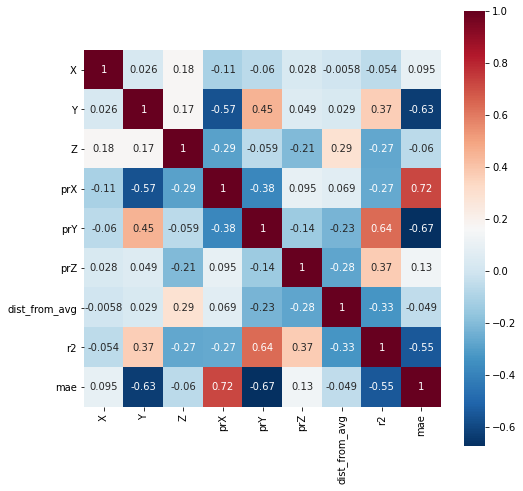

In [88]:
cols = locdir.columns[1:].tolist()
cols.remove('slab')
cmat = pandas.DataFrame(np.corrcoef(locdir[cols].T),
                        index=cols,columns=cols)
plt.subplots(figsize=(8,8))
sns.heatmap(cmat,annot=True,square=True,cmap='RdBu_r')

In [146]:
rgb_conv = MinMaxScaler().fit_transform(locdir[['prX','prY','prZ']]
                                       ).round(3)
#rgb_conv = tuple(map(tuple, rgb_conv))

r = x (medial-lateral)

g = y (anterior-posterior)

b = z (ventral-dorsal

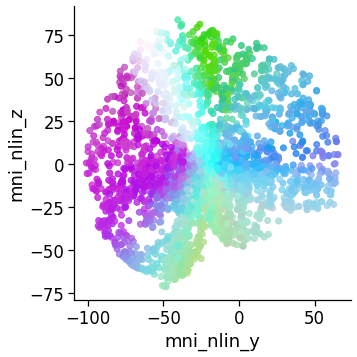

In [163]:
sns.lmplot(x='mni_nlin_y',y='mni_nlin_z',data=gdf,fit_reg=False,
           scatter_kws={'color':rgb_conv})

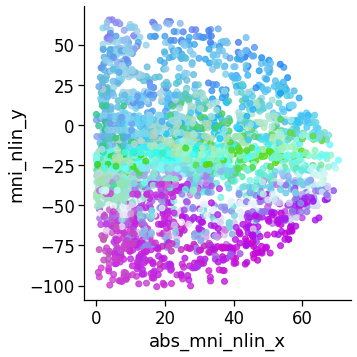

In [162]:
sns.lmplot(x='abs_mni_nlin_x',y='mni_nlin_y',data=gdf,fit_reg=False,
           scatter_kws={'color':rgb_conv})

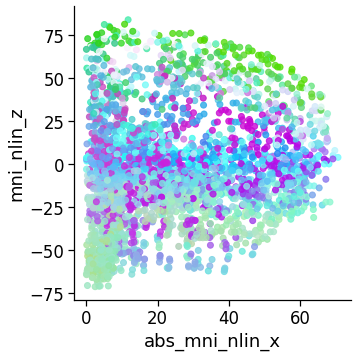

In [164]:
sns.lmplot(x='abs_mni_nlin_x',y='mni_nlin_z',data=gdf,fit_reg=False,
           scatter_kws={'color':rgb_conv})

# Now repeat by training *and* testing locally

In [165]:
tr_size = 0.90
cut = int(round(len(full_y)*tr_size))
locdir2 = pandas.DataFrame()
for i,row in gdf.iterrows():
    if i % 100 == 0: print('working on',i)
    source_dist = dm.loc[i].sort_values()
    te_idx = source_dist.index[cut:]
    teX = pca_tfm.loc[te_idx]
    teY = full_y.loc[te_idx]
    
    pls_mod = PLSRegression(n_components=3)
    predicted = cross_val_predict(pls_mod,teX,teY)
    r2 = r2_score(teY,predicted)
    mae = mean_absolute_error(teY,predicted)
    locdir2.loc[i,'idx'] = i
    locdir2.loc[i,'X'] = full_y.loc[i,'abs_mni_nlin_x']
    locdir2.loc[i,'Y'] = full_y.loc[i,'mni_nlin_y']
    locdir2.loc[i,'Z'] = full_y.loc[i,'mni_nlin_z']
    locdir2.loc[i,'prX'] = stats.pearsonr(predicted[:,2],
                                         full_y.loc[te_idx,'abs_mni_nlin_x']
                                        )[0]
    locdir2.loc[i,'prY'] = stats.pearsonr(predicted[:,0],
                                         full_y.loc[te_idx,'mni_nlin_y']
                                        )[0]
    locdir2.loc[i,'prZ'] = stats.pearsonr(predicted[:,1],
                                         full_y.loc[te_idx,'mni_nlin_z']
                                        )[0]
    locdir2.loc[i,'dist_from_avg'] = source_dist.mean()
    locdir2.loc[i,'slab'] = gdf.loc[i,'slab_type']
    locdir2.loc[i,'r2'] = r2
    locdir2.loc[i,'mae'] = mae

working on 0
working on 100
working on 200
working on 300
working on 400
working on 500
working on 600
working on 700
working on 800
working on 900
working on 1000
working on 1100
working on 1200
working on 1300
working on 1400
working on 1500
working on 1600
working on 1700
working on 1800
working on 1900
working on 2000
working on 2100
working on 2200
working on 2300
working on 2400
working on 2500
working on 2600
working on 2700
working on 2800
working on 2900
working on 3000
working on 3100
working on 3200
working on 3300
working on 3400


<AxesSubplot:>

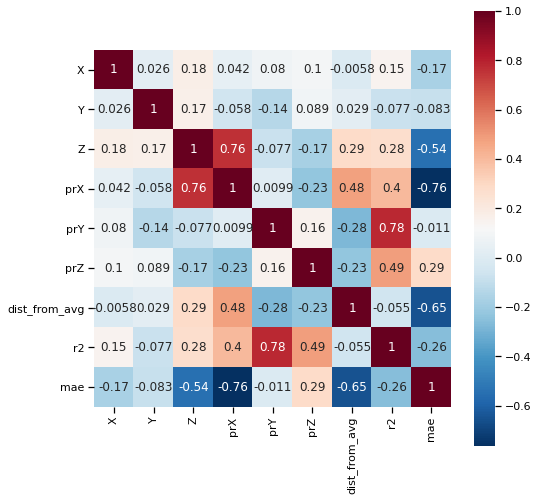

In [169]:
sns.set_context('notebook',font_scale=1)
cols = locdir2.columns[1:].tolist()
cols.remove('slab')
cmat = pandas.DataFrame(np.corrcoef(locdir2[cols].T),
                        index=cols,columns=cols)
plt.subplots(figsize=(8,8))
sns.heatmap(cmat,annot=True,square=True,cmap='RdBu_r')

In [170]:
rgb_conv = MinMaxScaler().fit_transform(locdir2[['prX','prY','prZ']]
                                       ).round(3)
#rgb_conv = tuple(map(tuple, rgb_conv))

r = x (medial-lateral)

g = y (anterior-posterior)

b = z (ventral-dorsal

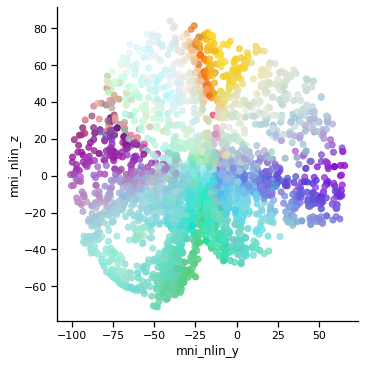

In [171]:
sns.lmplot(x='mni_nlin_y',y='mni_nlin_z',data=gdf,fit_reg=False,
           scatter_kws={'color':rgb_conv})

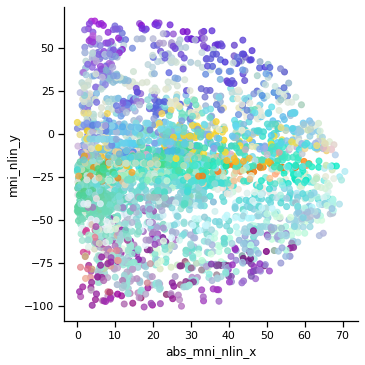

In [172]:
sns.lmplot(x='abs_mni_nlin_x',y='mni_nlin_y',data=gdf,fit_reg=False,
           scatter_kws={'color':rgb_conv})

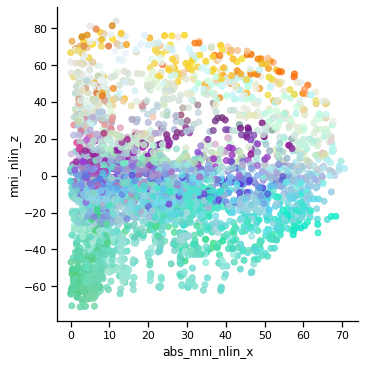

In [173]:
sns.lmplot(x='abs_mni_nlin_x',y='mni_nlin_z',data=gdf,fit_reg=False,
           scatter_kws={'color':rgb_conv})

In [177]:
lmap

{0: 'Sensorimotor',
 1: 'Insula',
 2: 'Thalamus',
 3: 'Limbic',
 4: 'DCN',
 5: 'Striatum',
 6: 'Forebrain',
 7: 'Tegmentum',
 8: 'Temporal',
 9: 'Frontal',
 10: 'Posterior_Cingulate',
 11: nan,
 12: 'Parietal',
 13: 'Anterior_Cingulate',
 14: 'Occipital',
 15: 'Hypothalamus',
 16: 'Pons',
 17: 'Medulla',
 18: 'Cerebellum',
 20: 'Other_Dien',
 999: 'NaN'}

In [182]:
rgb_conv[l_index]

array([[0.92 , 0.884, 0.672],
       [0.935, 0.895, 0.765]])

In [183]:
code = dict(zip(gdfBD.brain_divison.unique().tolist(),
               range(len(gdfBD.brain_divison.unique().tolist()))))
labs = [code[x] if pandas.notnull(x) else 999 for x in gdfBD.brain_divison.values]
embedding = gdf[['abs_mni_nlin_x','mni_nlin_y','mni_nlin_z']].values

lmap = {v: k for k, v in code.items()}
#lmap.pop(19)
lmap.update({999: 'NaN'})
traces = list()
for lab in np.unique(labs):
    l_index = [x for x in range(len(labs)) if labs[x] == lab]
    l_embed = embedding[l_index]
#     color_str = str(int('0x' + color_dict[lab][1:3].upper(),16)) + ',' + \
#                    str(int('0x' + color_dict[lab][3:5].upper(),16)) + ',' + \
#                    str(int('0x' + color_dict[lab][5:7].upper(),16))
    #color_str = plt.cm.tab10.colors[lab]
    #color_str = 'rgba %s'%str(tuple([x - 0.0000001 for x in plt.cm.tab20(lab) if x > 0]))
    temp_trace = plotly.graph_objs.Scatter3d(x=l_embed[:,0],
                                            y = l_embed[:,1],
                                            z = l_embed[:,2],
                                            name = lmap[lab],
                                            mode = 'markers',
                                            marker = dict(size=5,
                                                          color=rgb_conv[l_index]
                                                         )
                                            )
    traces.append(temp_trace)

layout = plotly.graph_objs.Layout(margin = dict(l=0,r=0,b=0,t=0))

fig = plotly.graph_objs.Figure(data=traces, layout=layout)
plotly.offline.plot(fig, 
                    filename='/Users/jacobv/Science/PLS_GXP/txfer/RGB_LocDir_3D')
    

/Users/jacobv/jakepy/lib/python3.7/site-packages/plotly/offline/offline.py:563: UserWarning:

Your filename `/Users/jacobv/Science/PLS_GXP/txfer/RGB_LocDir_3D` didn't end with .html. Adding .html to the end of your file.



'/Users/jacobv/Science/PLS_GXP/txfer/RGB_LocDir_3D.html'

# Separately for brainstem/cerebellum/cortex

In [21]:
bigdf.loc[gdf[gdf.slab_type=='CX'].index,:].shape

(2700, 15633)

In [46]:
results = pandas.DataFrame()
n_iter = 100
i = 0
for slab in gdf.slab_type.unique():
    print('======WORKING ON %s SLAB======='%slab)
    data = pandas.DataFrame(bigdf.loc[gdf[gdf.slab_type==slab].index,:],
                           copy=True)
    for it in range(n_iter):
        trX,teX = train_test_split(data,random_state=123+it,shuffle=True)
        trY,teY = full_y.loc[trX.index],full_y.loc[teX.index]
        clf_base = PLSRegression(n_components=3)
        clf_pca = Pipeline([('pca',PCA(n_components=50, random_state=123)),
                             ('pls',clf_base)])
        ### PCA MODELS
        clf_pca.fit(trX,trY)
        # self
        pred = clf_pca.predict(teX)
        results.loc[i,'iteration'] = it
        results.loc[i,'source'] = slab
        results.loc[i,'target'] = slab
        results.loc[i,'PCA'] = 'local'
        results.loc[i,'r2'] = r2_score(teY,pred) 
        results.loc[i,'mae'] = mean_absolute_error(teY,pred)
        i+=1
        # other slabs
        for target in gdf.slab_type.unique():
            if target==slab: continue
            tdata = pandas.DataFrame(bigdf.loc[gdf[gdf.slab_type==target].index,:],
                                     copy=True)
            ty = full_y.loc[tdata.index]
            pred = clf_pca.predict(tdata)
            results.loc[i,'iteration'] = it
            results.loc[i,'source'] = slab
            results.loc[i,'target'] = target
            results.loc[i,'PCA'] = 'local'
            results.loc[i,'r2'] = r2_score(ty,pred) 
            results.loc[i,'mae'] = mean_absolute_error(ty,pred)
            i+=1
        # full dataset
        tids = [x for x in bigdf.index if x not in tr.index]
        tdata = bigdf.loc[tids]
        ty = full_y.loc[tdata.index]
        pred = clf_pca.predict(tdata)
        results.loc[i,'iteration'] = it
        results.loc[i,'source'] = slab
        results.loc[i,'target'] = 'global'
        results.loc[i,'PCA'] = 'local'
        results.loc[i,'r2'] = r2_score(ty,pred) 
        results.loc[i,'mae'] = mean_absolute_error(ty,pred)
        i+=1
            
        ### wb models
        
        trX,teX = pca_tfm.loc[trX.index],pca_tfm.loc[teX.index]
        ### PCA MODELS
        clf_base.fit(trX,trY)
        # self
        pred = clf_base.predict(teX)
        results.loc[i,'iteration'] = it
        results.loc[i,'source'] = slab
        results.loc[i,'target'] = slab
        results.loc[i,'PCA'] = 'global'
        results.loc[i,'r2'] = r2_score(teY,pred) 
        results.loc[i,'mae'] = mean_absolute_error(teY,pred)
        i+=1
        # other slabs
        for target in gdf.slab_type.unique():
            if target==slab: continue
            tdata = pandas.DataFrame(pca_tfm.loc[gdf[gdf.slab_type==target].index],
                                     copy=True)
            ty = full_y.loc[tdata.index]
            pred = clf_base.predict(tdata)
            results.loc[i,'iteration'] = it
            results.loc[i,'source'] = slab
            results.loc[i,'target'] = target
            results.loc[i,'PCA'] = 'global'
            results.loc[i,'r2'] = r2_score(ty,pred) 
            results.loc[i,'mae'] = mean_absolute_error(ty,pred)
            i+=1
        # full dataset
        tids = [x for x in bigdf.index if x not in tr.index]
        tdata = pca_tfm.loc[tids]
        ty = full_y.loc[tids]
        pred = clf_base.predict(tdata)
        results.loc[i,'iteration'] = it
        results.loc[i,'source'] = slab
        results.loc[i,'target'] = 'global'
        results.loc[i,'PCA'] = 'global'
        results.loc[i,'r2'] = r2_score(ty,pred) 
        results.loc[i,'mae'] = mean_absolute_error(ty,pred)
        i+=1
        
        results.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ADDX/XSlab.csv')
        if it%10 == 0:
            print('finished iteration',it)

======WORKING ON CX SLAB=======
finished iteration 0
finished iteration 10
finished iteration 20
finished iteration 30
finished iteration 40
finished iteration 50
finished iteration 60
finished iteration 70
finished iteration 80


/home/users/jvogel/venvs/py3.7/lib/python3.5/site-packages/sklearn/cross_decomposition/_pls.py:96: ConvergenceWarning:

Maximum number of iterations reached



finished iteration 90
======WORKING ON BS SLAB=======
finished iteration 0
finished iteration 10
finished iteration 20
finished iteration 30
finished iteration 40
finished iteration 50
finished iteration 60
finished iteration 70
finished iteration 80
finished iteration 90
======WORKING ON CB SLAB=======
finished iteration 0
finished iteration 10
finished iteration 20
finished iteration 30
finished iteration 40
finished iteration 50
finished iteration 60
finished iteration 70
finished iteration 80
finished iteration 90


(0, 1)

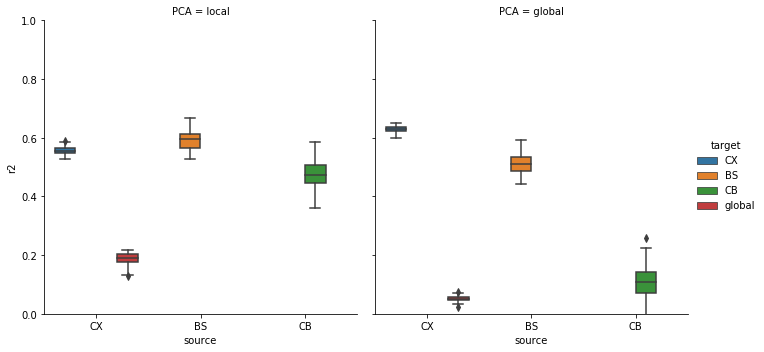

In [49]:
sns.catplot(x='source',y='r2',hue='target',col='PCA',data=results,
            kind='box')
plt.ylim(0,1)

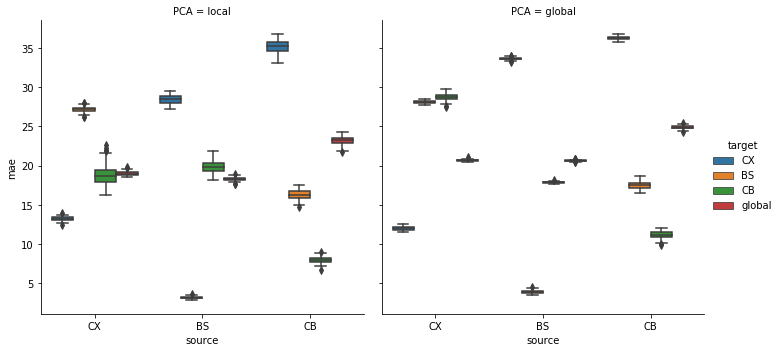

In [51]:
sns.catplot(x='source',y='mae',hue='target',col='PCA',data=results,
            kind='box')


# Plot the components for each slab

# Compare global model to the other two models

# See if models predict other dimension of other slabs?

running PCA
explained variance with PCA: 0.8374639392110836
transforming and splitting
fitting model to training data
evaluating output
finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400


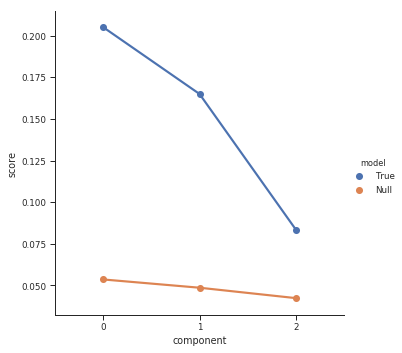

component 0: p = 0.002  ***
component 1: p = 0.002  ***
component 2: p = 0.002  ***
applying to test data


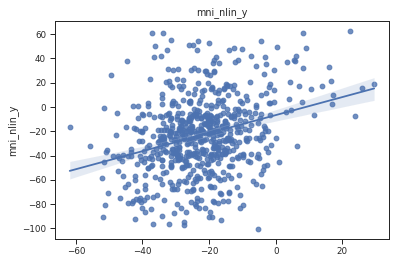

(0.3028372195280676, 8.768017012402718e-16)
23.298224465995965


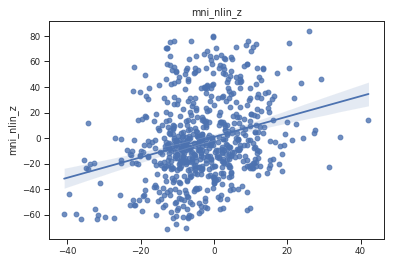

(0.2786526502784122, 1.6719488060107164e-13)
24.575748211224013


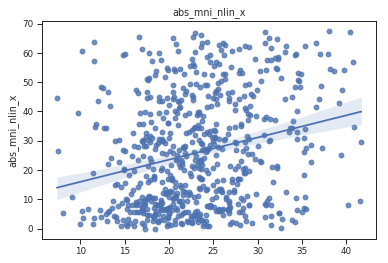

(0.25339994973018976, 2.3786899040333106e-11)
15.270640774688093


In [113]:
print('running PCA')
pcamod = PCA(n_components=100, random_state=123).fit(bigdf.values[gdf[gdf.slab_type=='CX'].index,:])
print('explained variance with PCA:',sum(pcamod.explained_variance_ratio_))
print('transforming and splitting')
pca_tfm = pandas.DataFrame(pcamod.transform(bigdf.values[gdf[gdf.slab_type=='CX'].index,:]))
tr,te = train_test_split(pca_tfm,random_state=123)
tr_y = gdf.loc[tr.index, ['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
te_y = gdf.loc[te.index, ['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
print('fitting model to training data')
pls_mod = PLSRegression(n_components=3)
# significant components?
print('evaluating output')
pls_mod.fit(tr,tr_y)
results, comp_sig = XD.evaluate_components(pls_mod, tr, tr_y)
# plot model fit
print('applying to test data')
pls_mod.fit(tr,tr_y)
te_pred = pls_mod.predict(te)
for i in range(te_y.shape[-1]):
    plt.close()
    sns.regplot(te_pred[:,i], te_y[te_y.columns[i]])
    plt.title(te_y.columns[i])
    plt.show()
    print(stats.pearsonr(te_pred[:,i], te_y[te_y.columns[i]]))
    print(mean_absolute_error(te_pred[:,i], te_y[te_y.columns[i]]))


running PCA
explained variance with PCA: 0.9445330684121362
transforming and splitting
fitting model to training data
evaluating output
finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400


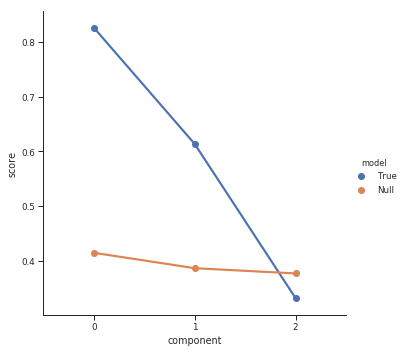

component 0: p = 0.002  ***
component 1: p = 0.002  ***
component 2: p = 0.834
applying to test data


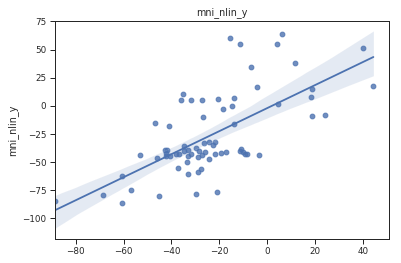

(0.6631987835252983, 2.1874693010883682e-10)
21.361476897263273


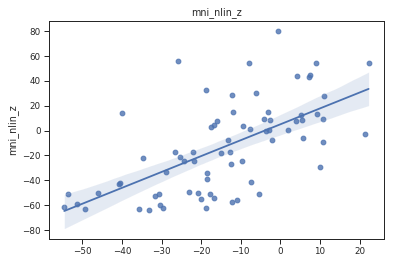

(0.6241689956589495, 4.681381186643695e-09)
22.128327981825617


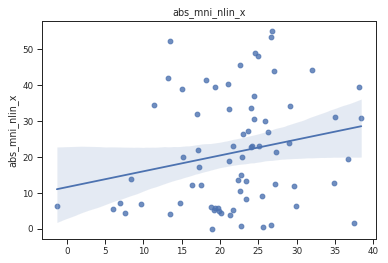

(0.2180636513683218, 0.06574460484569797)
12.581998867276816


In [114]:
print('running PCA')
pcamod = PCA(n_components=100, random_state=123).fit(bigdf.values[gdf[gdf.slab_type=='CB'].index,:])
print('explained variance with PCA:',sum(pcamod.explained_variance_ratio_))
print('transforming and splitting')
pca_tfm = pandas.DataFrame(pcamod.transform(bigdf.values[gdf[gdf.slab_type=='CB'].index,:]))
tr,te = train_test_split(pca_tfm,random_state=123)
tr_y = gdf.loc[tr.index, ['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
te_y = gdf.loc[te.index, ['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
print('fitting model to training data')
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(tr,tr_y)
# significant components?
print('evaluating output')
results, comp_sig = XD.evaluate_components(pls_mod, tr, tr_y)
# plot model fit
print('applying to test data')
pls_mod.fit(tr,tr_y)
te_pred = pls_mod.predict(te)
for i in range(te_y.shape[-1]):
    plt.close()
    sns.regplot(te_pred[:,i], te_y[te_y.columns[i]])
    plt.title(te_y.columns[i])
    plt.show()
    print(stats.pearsonr(te_pred[:,i], te_y[te_y.columns[i]]))
    print(mean_absolute_error(te_pred[:,i], te_y[te_y.columns[i]]))


running PCA
explained variance with PCA: 0.821231936645413
transforming and splitting
fitting model to training data
evaluating output
finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400


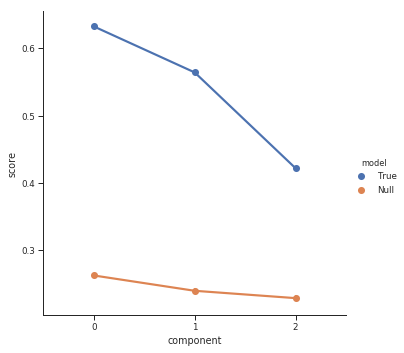

component 0: p = 0.002  ***
component 1: p = 0.002  ***
component 2: p = 0.002  ***
applying to test data


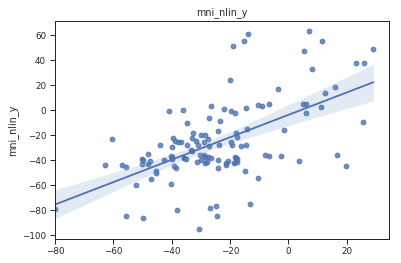

(0.5778511483739538, 3.9326025267145235e-12)
19.122360788864555


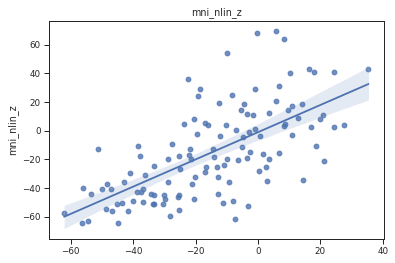

(0.6543529326997343, 3.9792770532242817e-16)
18.702405493032046


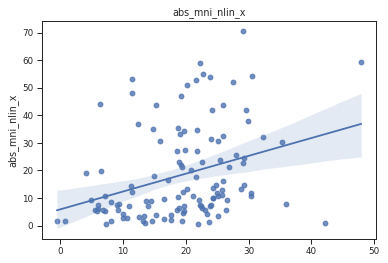

(0.32733943520921854, 0.00024747393916692924)
12.602596145417685


In [115]:
print('running PCA')
pcamod = PCA(n_components=100, random_state=123).fit(bigdf.values[gdf[gdf.slab_type=='BS'].index,:])
print('explained variance with PCA:',sum(pcamod.explained_variance_ratio_))
print('transforming and splitting')
pca_tfm = pandas.DataFrame(pcamod.transform(bigdf.values[gdf[gdf.slab_type=='BS'].index,:]))
tr,te = train_test_split(pca_tfm,random_state=123)
tr_y = gdf.loc[tr.index, ['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
te_y = gdf.loc[te.index, ['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
print('fitting model to training data')
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(tr,tr_y)
# significant components?
print('evaluating output')
results, comp_sig = XD.evaluate_components(pls_mod, tr, tr_y)
# plot model fit
print('applying to test data')
pls_mod.fit(tr,tr_y)
te_pred = pls_mod.predict(te)
for i in range(te_y.shape[-1]):
    plt.close()
    sns.regplot(te_pred[:,i], te_y[te_y.columns[i]])
    plt.title(te_y.columns[i])
    plt.show()
    print(stats.pearsonr(te_pred[:,i], te_y[te_y.columns[i]]))
    print(mean_absolute_error(te_pred[:,i], te_y[te_y.columns[i]]))


#### now again with PCA from whole brain

In [117]:
pcamod = PCA(n_components=100, random_state=123).fit(bigdf)
sum(pcamod.explained_variance_ratio_)

0.846047690073279

transforming and splitting
fitting model to training data
evaluating output
finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400


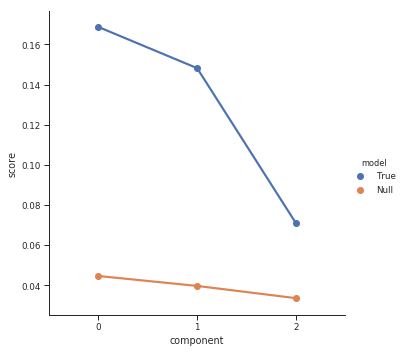

component 0: p = 0.002  ***
component 1: p = 0.002  ***
component 2: p = 0.002  ***
applying to test data


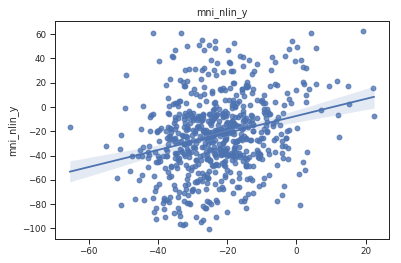

(0.2692246620166155, 1.1317809247041177e-12)
23.70978974550569


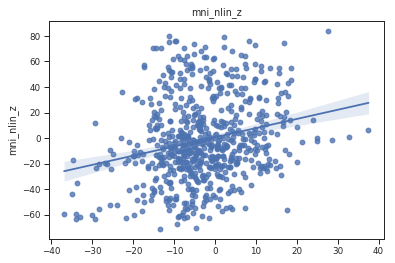

(0.23298174426703885, 8.993163301375036e-10)
24.59035313463408


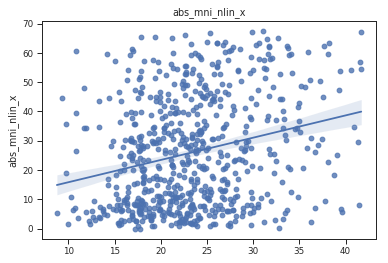

(0.25391898763952403, 2.159527435221041e-11)
15.392817590925201


In [118]:
print('transforming and splitting')
pca_tfm = pandas.DataFrame(pcamod.transform(bigdf.values[gdf[gdf.slab_type=='CX'].index,:]))
tr,te = train_test_split(pca_tfm,random_state=123)
tr_y = gdf.loc[tr.index, ['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
te_y = gdf.loc[te.index, ['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
print('fitting model to training data')
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(tr,tr_y)
# significant components?
print('evaluating output')
results, comp_sig = XD.evaluate_components(pls_mod, tr, tr_y)
pls_mod.fit(tr,tr_y)
# plot model fit
print('applying to test data')
te_pred = pls_mod.predict(te)
for i in range(te_y.shape[-1]):
    plt.close()
    sns.regplot(te_pred[:,i], te_y[te_y.columns[i]])
    plt.title(te_y.columns[i])
    plt.show()
    print(stats.pearsonr(te_pred[:,i], te_y[te_y.columns[i]]))
    print(mean_absolute_error(te_pred[:,i], te_y[te_y.columns[i]]))


transforming and splitting
fitting model to training data
evaluating output
finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400


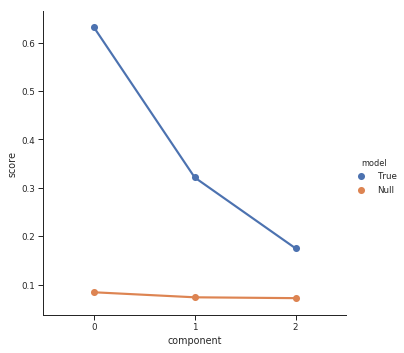

component 0: p = 0.002  ***
component 1: p = 0.002  ***
component 2: p = 0.002  ***
applying to test data


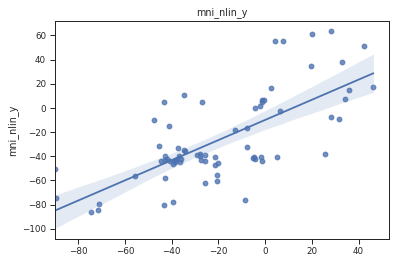

(0.7010173530828849, 7.054855252239744e-12)
20.962194458369396


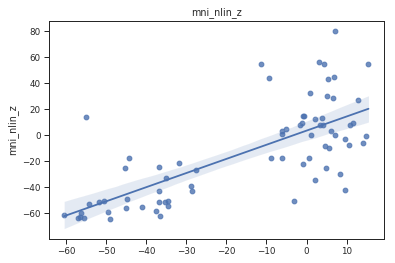

(0.7223894251851728, 7.916990356282946e-13)
18.66950528895868


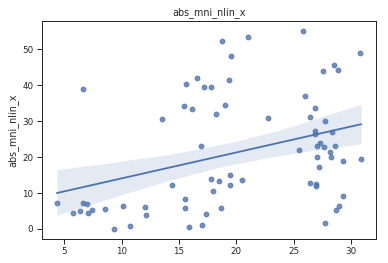

(0.3569353291700177, 0.0020856739823818704)
11.603377848137631


In [119]:
print('transforming and splitting')
pca_tfm = pandas.DataFrame(pcamod.transform(bigdf.values[gdf[gdf.slab_type=='CB'].index,:]))
tr,te = train_test_split(pca_tfm,random_state=123)
tr_y = gdf.loc[tr.index, ['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
te_y = gdf.loc[te.index, ['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
print('fitting model to training data')
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(tr,tr_y)
# significant components?
print('evaluating output')
results, comp_sig = XD.evaluate_components(pls_mod, tr, tr_y)
pls_mod.fit(tr,tr_y)
# plot model fit
print('applying to test data')
te_pred = pls_mod.predict(te)
for i in range(te_y.shape[-1]):
    plt.close()
    sns.regplot(te_pred[:,i], te_y[te_y.columns[i]])
    plt.title(te_y.columns[i])
    plt.show()
    print(stats.pearsonr(te_pred[:,i], te_y[te_y.columns[i]]))
    print(mean_absolute_error(te_pred[:,i], te_y[te_y.columns[i]]))


transforming and splitting
fitting model to training data
evaluating output
finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400


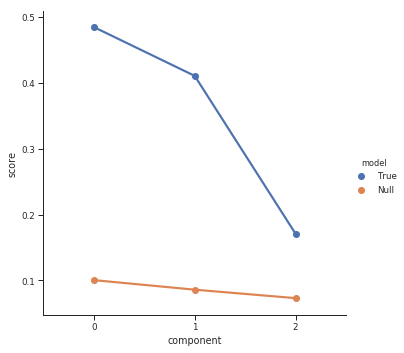

component 0: p = 0.002  ***
component 1: p = 0.002  ***
component 2: p = 0.002  ***
applying to test data


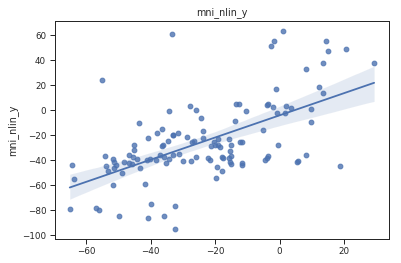

(0.5937175777686451, 7.113030048150821e-13)
18.946013034589622


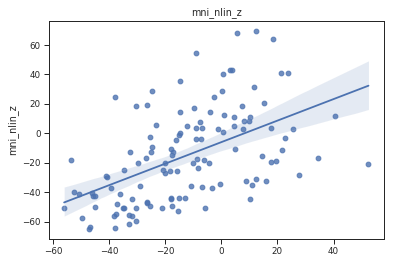

(0.5175504225463767, 1.2116844846592604e-09)
22.196921988489937


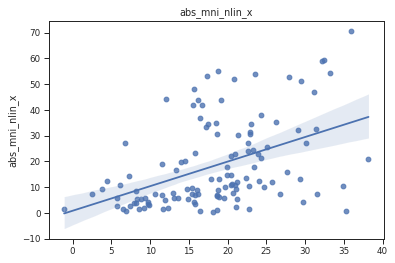

(0.4557271108382748, 1.500151582844603e-07)
11.769002398959628


In [120]:
print('transforming and splitting')
pca_tfm = pandas.DataFrame(pcamod.transform(bigdf.values[gdf[gdf.slab_type=='BS'].index,:]))
tr,te = train_test_split(pca_tfm,random_state=123)
tr_y = gdf.loc[tr.index, ['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
te_y = gdf.loc[te.index, ['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
print('fitting model to training data')
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(tr,tr_y)
# significant components?
print('evaluating output')
results, comp_sig = XD.evaluate_components(pls_mod, tr, tr_y)
pls_mod.fit(tr,tr_y)
# plot model fit
print('applying to test data')
te_pred = pls_mod.predict(te)
for i in range(te_y.shape[-1]):
    plt.close()
    sns.regplot(te_pred[:,i], te_y[te_y.columns[i]])
    plt.title(te_y.columns[i])
    plt.show()
    print(stats.pearsonr(te_pred[:,i], te_y[te_y.columns[i]]))
    print(mean_absolute_error(te_pred[:,i], te_y[te_y.columns[i]]))


# Understanding the components

In [121]:
Medulla = ['arcuate nucleus of medulla, left','arcuate nucleus of medulla, right',
                 'central glial substance',
                 'central medullary reticular group, left','central medullary reticular group, right',
                 'cochlear nuclei, left','cochlear nuclei, right',
                 'cuneate nucleus, left','cuneate nucleus, right',
                 'dorsal motor nucleus of the vagus, left','dorsal motor nucleus of the vagus, right',
                 'gigantocellular group, left','gigantocellular group, right',
                 'gracile nucleus, left','gracile nucleus, right',
                 'hypoglossal nucleus, left','hypoglossal nucleus, right',
                 'inferior olivary complex, left','inferior olivary complex, right',
                 'lateral medullary reticular group, left','lateral medullary reticular group, right',
                 'raphe nuclei of medulla',
                 'spinal trigeminal nucleus, left','spinal trigeminal nucleus, right',
                 'superior olivary complex, left','superior olivary complex, right',
                 'vestibular nuclei, left','vestibular nuclei, right']

Pons =          ['abducens nucleus, left','abducens nucleus, right',
                 'central gray of the pons, left','central gray of the pons, right',
                 'facial motor nucleus, left','facial motor nucleus, right',
                 'lateral parabrachial nucleus, left','lateral parabrachial nucleus, right',
                 'locus ceruleus, left','locus ceruleus, right',
                 'medial parabrachial nucleus, left','medial parabrachial nucleus, right',
                 'medial parabrachial nucleus,right',
                 'motor nucleus of trigeminal nerve, left','motor nucleus of trigeminal nerve, right',
                 'nucleus subceruleus, left','nucleus subceruleus, right',
                 'pontine nuclei, left','pontine nuclei, right',
                 'pontine raphe nucleus','pontine raphe nucleus, left',
                 'pontine reticular formation, left','pontine reticular formation, right',
                 'principal sensory nucleus of trigeminal nerve, left','principal sensory nucleus of trigeminal nerve, right',
                 ]

DCN = ['dentate nucleus, left',
       'dentate nucleus, right',
       'emboliform nucleus, left',
       'emboliform nucleus, right',
       'fastigial nucleus, left',
       'fastigial nucleus, right',
       'globose nucleus, left',
       'globose nucleus, right']

Cerebellum = [x for x in gdf[gdf.slab_type=='CB']['structure_name'].unique().tolist() if x not in DCN]

Tectum = ['inferior colliculus, left',
          'superior colliculus, left','superior colliculus, right',
          'pretectal region']

Tegmentum = ['central gray substance of midbrain, left','central gray substance of midbrain, right',
            'cuneiform nucleus, left','cuneiform nucleus, right',
            'Edinger-Westphal nucleus, left','Edinger-Westphal nucleus, right',
            'interstitial nucleus of Cajal, left','interstitial nucleus of Cajal, right',
            'midbrain raphe nuclei','midbrain raphe nuclei, left',
            'midbrain reticular formation, left','midbrain reticular formation, right',
            'nucleus of Darkschewitsch, left',
            'oculomotor nuclear complex, right','oculomotor nuclear complex, left',
            'red nucleus, left','red nucleus, right',
            'subcuneiform nucleus, left','subcuneiform nucleus, right',
            'substantia nigra, pars compacta, left','substantia nigra, pars compacta, right',
            'substantia nigra, pars reticulata, left','substantia nigra, pars reticulata, right',
            'trochlear nucleus, left','trochlear nucleus, right',
            'ventral tegmental area, left','ventral tegmental area, right']

Hypothalamus = ['anterior hypothalamic area, left','anterior hypothalamic area, right',
               'arcuate nucleus of the hypothalamus, left','arcuate nucleus of the hypothalamus, right',
               'dorsomedial hypothalamic nucleus, left',
               'lateral hypothalamic area, anterior region, left', 'lateral hypothalamic area, anterior region, right',
               'lateral hypothalamic area, mammillary region, left', 'lateral hypothalamic area, mammillary region, right',
               'lateral hypothalamic area, tuberal region, left',
               'paraventricular nucleus of the hypothalamus, left','paraventricular nucleus of the hypothalamus, right',
               'perifornical nucleus, left',
               'posterior hypothalamic area, left','posterior hypothalamic area, right',
               'preoptic region, left','preoptic region, right',
               'supraoptic nucleus, left','supraoptic nucleus, right',
               'ventromedial hypothalamic nucleus, left','ventromedial hypothalamic nucleus, right',]
                

Thalamus = ['anterior group of nuclei, left','anterior group of nuclei, right',
           'caudal group of intralaminar nuclei, left','caudal group of intralaminar nuclei, right',
           'dorsal lateral geniculate nucleus, left','dorsal lateral geniculate nucleus, right',
           'lateral group of nuclei, left, dorsal division','lateral group of nuclei, left, ventral division',
           'lateral group of nuclei, right, dorsal division','lateral group of nuclei, right, ventral division',
           'medial geniculate complex, left','medial geniculate complex, right',
           'medial group of nuclei, left','medial group of nuclei, right',
           'reticular nucleus of thalamus, left','reticular nucleus of thalamus, right',
           'rostral group of intralaminar nuclei, left','rostral group of intralaminar nuclei, right',
           'paraventricular nuclei, left of thalamus, left','paraventricular nuclei, right of thalamus, right',
           'posterior group of nuclei, left','posterior group of nuclei, right',
           'subthalamic nucleus, left','subthalamic nucleus, right',
           'zona incerta, left','zona incerta, right']

Other_Dien = ['lateral habenular nucleus, left','lateral habenular nucleus, right',
             'lateral mammillary nucleus, left',
             'lateral tuberal nucleus, left',
             'mammillary body, left','mammillary body, right',
             'medial habenular nucleus, left','medial habenular nucleus, right',
             'medial mammillary nucleus, left',
             'pallidohypothalamic nucleus, left',
             'pineal gland',
             'supramammillary nucleus, left',
             'tuberomammillary nucleus, left']

Limbic = ['CA1 field, left','CA1 field, right',
          'CA2 field, left','CA2 field, right',
          'CA3 field, left','CA3 field, right',
          'CA4 field, left','CA4 field, right',
          'amygdalohippocampal transition zone, left',
          'amygdalohippocampal transition zone, right',
          'basolateral nucleus, left','basolateral nucleus, right',
          'basomedial nucleus, left','basomedial nucleus, right',
          'central nucleus, left','central nucleus, right',
          'cortico-medial group, left','cortico-medial group, right',
          'dentate gyrus, left','dentate gyrus, right',
          'lateral nucleus, left','lateral nucleus, right',
          'septal nuclei, left','septal nuclei, right',
         'subiculum, left','subiculum, right']

Forebrain = ['basal nucleus of meynert, left','basal nucleus of meynert, right',
            'nucleus accumbens, left','nucleus accumbens, right',
            'nucleus of the diagonal band, left, horizontal division',
            'nucleus of the diagonal band, left, vertical division',
            'olfactory tubercle, left', 'piriform cortex, left',
            'substantia innominata, left','substantia innominata, right']

Striatum = ['bed  nucleus of stria terminalis, left',
            'body of caudate nucleus, left',
            'body of caudate nucleus, right',
            'globus pallidus, external segment, left','globus pallidus, external segment, right',
            'globus pallidus, internal segment, left','globus pallidus, internal segment, right',
            'head of caudate nucleus, left','head of caudate nucleus, right',
            'olfactory tubercle, left',
            'putamen, left','putamen, right',
           'tail of caudate nucleus, left','tail of caudate nucleus, right']

Anterior_Cingulate = ['cingulate gyrus, frontal part, left, inferior bank of gyrus',
                     'cingulate gyrus, frontal part, left, superior bank of gyrus',
                     'cingulate gyrus, frontal part, right, inferior bank of gyrus',
                     'cingulate gyrus, frontal part, right, superior bank of gyrus',
                     'paraterminal gyrus, right',
                     'parolfactory gyri, left','parolfactory gyri, right',
                     'subcallosal cingulate gyrus, left','subcallosal cingulate gyrus, right']

Posterior_Cingulate = ['cingulate gyrus, parietal part, left, inferior bank of gyrus',
                     'cingulate gyrus, parietal part, left, superior bank of gyrus',
                     'cingulate gyrus, parietal part, right, inferior bank of gyrus',
                     'cingulate gyrus, parietal part, right, superior bank of gyrus',
                     'cingulate gyrus, retrosplenial part, left, inferior bank of gyrus',
                     'cingulate gyrus, retrosplenial part, left, superior bank of gyrus',
                     'cingulate gyrus, retrosplenial part, right, inferior bank of gyrus',
                     'cingulate gyrus, retrosplenial part, right, superior bank of gyrus',]

Insula = ['claustrum, left','claustrum, right',
         'long insular gyri, left','long insular gyri, right',
         'short insular gyri, left','short insular gyri, right',]

Temporal = ["Heschl's gyrus, left", "Heschl's gyrus, right",
           'fusiform gyrus, left, bank of cos','fusiform gyrus, left, bank of the its',
           'fusiform gyrus, left, lateral bank of gyrus','fusiform gyrus, right, bank of cos',
           'fusiform gyrus, right, bank of the its','fusiform gyrus, right, lateral bank of gyrus',
           'inferior temporal gyrus, left, bank of mts','inferior temporal gyrus, left, bank of the its',
           'inferior temporal gyrus, left, lateral bank of gyrus','inferior temporal gyrus, right, bank of mts',
           'inferior temporal gyrus, right, bank of the its','inferior temporal gyrus, right, lateral bank of gyrus',
           'middle temporal gyrus, left, inferior bank of gyrus','middle temporal gyrus, left, superior bank of gyrus',
           'middle temporal gyrus, right, inferior bank of gyrus','middle temporal gyrus, right, superior bank of gyrus',
           'occipito-temporal gyrus, left, inferior bank of gyrus','occipito-temporal gyrus, left, superior bank of gyrus',
           'occipito-temporal gyrus, right, inferior bank of gyrus','occipito-temporal gyrus, right, superior bank of gyrus',
           'parahippocampal gyrus, left, bank of the cos','parahippocampal gyrus, left, lateral bank of gyrus',
           'parahippocampal gyrus, right, bank of the cos','parahippocampal gyrus, right, lateral bank of gyrus',
           'superior temporal gyrus, left, inferior bank of gyrus','superior temporal gyrus, left, lateral bank of gyrus',
           'superior temporal gyrus, right, inferior bank of gyrus','superior temporal gyrus, right, lateral bank of gyrus',
           'temporal pole, left, inferior aspect','temporal pole, left, medial aspect',
           'temporal pole, left, superior aspect','temporal pole, right, inferior aspect',
           'temporal pole, right, medial aspect','temporal pole, right, superior aspect',
           'transverse gyri, left','transverse gyri, right',
           'planum polare, left','planum polare, right',
           'planum temporale, left','planum temporale, right']

Parietal = ['angular gyrus, left, inferior bank of gyrus','angular gyrus, left, superior bank of gyrus',
            'angular gyrus, right, inferior bank of gyrus','angular gyrus, right, superior bank of gyrus',
            'precuneus, left, inferior lateral bank of gyrus','precuneus, left, superior lateral bank of gyrus',
            'precuneus, right, inferior lateral bank of gyrus','precuneus, right, superior lateral bank of gyrus',
            'superior parietal lobule, left, inferior bank of gyrus','superior parietal lobule, left, superior bank of gyrus',
            'superior parietal lobule, right, inferior bank of gyrus','superior parietal lobule, right, superior bank of gyrus',
            'supramarginal gyrus, left, inferior bank of gyrus','supramarginal gyrus, left, superior bank of gyrus',
            'supramarginal gyrus, right, inferior bank of gyrus','supramarginal gyrus, right, superior bank of gyrus']

Frontal = ['anterior orbital gyrus, left','anterior orbital gyrus, right',
           'arcuate nucleus of the hypothalamus, left','arcuate nucleus of the hypothalamus, right',
          'frontal operculum, left','frontal operculum, right',
          'frontal pole, left, inferior aspect','frontal pole, left, medial aspect',
          'frontal pole, left, superior aspect','frontal pole, right, inferior aspect',
          'frontal pole, right, medial aspect','frontal pole, right, superior aspect',
          'gyrus rectus, left','gyrus rectus, right',
          'inferior frontal gyrus, opercular part, left','inferior frontal gyrus, opercular part, right',
          'inferior frontal gyrus, orbital part, left','inferior frontal gyrus, orbital part, right',
          'inferior frontal gyrus, triangular part, left','inferior frontal gyrus, triangular part, right',
          'inferior rostral gyrus, left','inferior rostral gyrus, right',
          'lateral orbital gyrus, left','lateral orbital gyrus, right',
          'medial orbital gyrus, left','medial orbital gyrus, right',
          'middle frontal gyrus, left, inferior bank of gyrus','middle frontal gyrus, left, superior bank of gyrus',
          'middle frontal gyrus, right, inferior bank of gyrus','middle frontal gyrus, right, superior bank of gyrus',
          'posterior orbital gyrus, left','posterior orbital gyrus, right',
          'superior frontal gyrus, left','superior frontal gyrus, left, lateral bank of gyrus',
          'superior frontal gyrus, left, medial bank of gyrus','superior frontal gyrus, right, lateral bank of gyrus',
          'superior frontal gyrus, right, medial bank of gyrus',
          'superior rostral gyrus, left','superior rostral gyrus, right']

Occipital = ['cuneus, left, peristriate',
             'cuneus, left, striate',
             'cuneus, right, peristriate',
             'cuneus, right, striate',
             'inferior occipital gyrus, left, inferior bank of gyrus','inferior occipital gyrus, left, superior bank of gyrus',
             'inferior occipital gyrus, right, inferior bank of gyrus','inferior occipital gyrus, right, superior bank of gyrus',
             'lingual gyrus, left, peristriate','lingual gyrus, left, striate',
             'lingual gyrus, right, peristriate','lingual gyrus, right, striate',
             'occipital pole, left, inferior aspect',
             'occipital pole, left, lateral aspect','occipital pole, left, superior aspect',
             'superior occipital gyrus, left, inferior bank of gyrus','superior occipital gyrus, left, superior bank of gyrus',
             'superior occipital gyrus, right, inferior bank of gyrus','superior occipital gyrus, right, superior bank of gyrus',]

Sensorimotor = ['paracentral lobule, anterior part, left','paracentral lobule, anterior part, left, inferior bank of gyrus',
                'paracentral lobule, anterior part, left, superior bank of gyrus','paracentral lobule, anterior part, right, inferior bank of gyrus',
                'paracentral lobule, anterior part, right, superior bank of gyrus','paracentral lobule, posterior part, left, bank of cingulate sulcus',
                'paracentral lobule, posterior part, left, lateral bank of gyrus','paracentral lobule, posterior part, right, bank of cingulate sulcus',
                'paracentral lobule, posterior part, right, lateral bank of gyrus',
                'postcentral gyrus, left, bank of the central sulcus','postcentral gyrus, left, bank of the posterior central sulcus',
                'postcentral gyrus, left, inferior lateral aspect of gyrus','postcentral gyrus, left, superior lateral aspect of gyrus',
                'postcentral gyrus, right, bank of the central sulcus','postcentral gyrus, right, bank of the posterior central sulcus',
                'postcentral gyrus, right, inferior lateral aspect of gyrus','postcentral gyrus, right, superior lateral aspect of gyrus',
                'precentral gyrus, left, bank of the central sulcus','precentral gyrus, left, bank of the precentral sulcus',
                'precentral gyrus, left, inferior lateral aspect of gyrus','precentral gyrus, left, superior lateral aspect of gyrus',
                'precentral gyrus, right, bank of the central sulcus','precentral gyrus, right, bank of the precentral sulcus',
                'precentral gyrus, right, inferior lateral aspect of gyrus','precentral gyrus, right, superior lateral aspect of gyrus']
            
divs = [Medulla, Pons, DCN, Cerebellum, Tectum, Tegmentum, Hypothalamus, Thalamus, Other_Dien,
                  Limbic, Forebrain, Striatum, Anterior_Cingulate, Posterior_Cingulate, Insula,
                  Temporal, Frontal, Parietal, Occipital, Sensorimotor]
names = ['Medulla', 'Pons', 'DCN', 'Cerebellum', 'Tectum', 'Tegmentum', 'Hypothalamus', 'Thalamus', 
         'Other_Dien', 'Limbic', 'Forebrain', 'Striatum', 'Anterior_Cingulate', 'Posterior_Cingulate', 
         'Insula', 'Temporal', 'Frontal', 'Parietal', 'Occipital', 'Sensorimotor']
brain_division = dict(zip(names,divs))

for name, div in brain_division.items():
    gdf.loc[gdf[gdf.structure_name.isin(div)].index,'brain_divison'] = name
    

In [122]:
# For C1
Meyelencephalon = Medulla[:] 
Metencelphalon = Pons + DCN + Cerebellum
Mesencephalon = Tectum + Tegmentum
Diencephalon = Hypothalamus + Thalamus + Other_Dien
Telencephalon = Limbic + Forebrain + Striatum + Anterior_Cingulate + Posterior_Cingulate +\
                Insula + Temporal + Frontal + Parietal + Occipital + Sensorimotor

divs = [Meyelencephalon, Metencelphalon, Mesencephalon, Diencephalon, Telencephalon]
names = ['Meyelencephalon', 'Metencelphalon', 'Mesencephalon', 'Diencephalon', 'Telencephalon']
brain_division = dict(zip(names,divs))

for name, div in brain_division.items():
    gdf.loc[gdf[gdf.structure_name.isin(div)].index,'Neural_Tube_segment'] = name
    

In [123]:
# For C3

Auditory = ["Heschl's gyrus, left", "Heschl's gyrus, right",
            'planum polare, left','planum polare, right',
            'planum temporale, left','planum temporale, right',
            'transverse gyri, left','transverse gyri, right']
Visual = ['cuneus, left, peristriate','cuneus, left, striate',
                 'cuneus, right, peristriate','cuneus, right, striate',
                 'lingual gyrus, left, peristriate','lingual gyrus, left, striate',
                 'lingual gyrus, right, peristriate','lingual gyrus, right, striate']
Olfactory = ['olfactory tubercle, left', 'piriform cortex, left']


Sensory_Cortex = Sensorimotor + Auditory + Visual + Olfactory
gdf.loc[gdf[gdf.structure_name.isin(Sensory_Cortex)].index,'Cortical_Type'] = 'Sensory'

Association_Cortex = [x for x in Telencephalon if x not in Striatum and x not in Sensory_Cortex]
gdf.loc[gdf[gdf.structure_name.isin(Association_Cortex)].index,'Cortical_Type'] = 'Association_Cortex'

Not_Cortex = Meyelencephalon + Mesencephalon + Metencelphalon + Diencephalon + Striatum
gdf.loc[gdf[gdf.structure_name.isin(Not_Cortex)].index,'Cortical_Type'] = 'Not Cortex'


divs = [Auditory, Visual, Olfactory, Sensorimotor, Association_Cortex, Not_Cortex]
names = ['Auditory','Visual','Olfactory','Sensorimotor','Association_Cortex','Not_Cortex']
brain_division = dict(zip(names,divs))
for name, div in brain_division.items():
    gdf.loc[gdf[gdf.structure_name.isin(div)].index,'Sensory_Type'] = name


In [124]:
# for c2
alar_medulla = ['spinal trigeminal nucleus, right', 'spinal trigeminal nucleus, left',
               'cochlear nuclei, left','cochlear nuclei, right',
               'vestibular nuclei, left','vestibular nuclei, right',
               'inferior olivary complex, left','inferior olivary complex, right',
                'gracile nucleus, left','gracile nucleus, right',
               'cuneate nucleus, left','cuneate nucleus, right',
               'superior olivary complex, left','superior olivary complex, right',]

basal_medulla = ['hypoglossal nucleus, left','hypoglossal nucleus, right',
                'lateral medullary reticular group, left','lateral medullary reticular group, right',
                'dorsal motor nucleus of the vagus, left','dorsal motor nucleus of the vagus, right', 
                'arcuate nucleus of medulla, left','arcuate nucleus of medulla, right',
                'central medullary reticular group, left','central medullary reticular group, right',
                'raphe nuclei of medulla',
                'gigantocellular group, left','gigantocellular group, right', ]


divs = [alar_medulla, basal_medulla]
names = ['Alar_Medulla','Basal_Medulla']
med_division = dict(zip(names,divs))

for name, div in med_division.items():
    gdf.loc[gdf[gdf.structure_name.isin(div)].index,'brain_divison'] = name

dorsal_plate = ['Cerebellum', 'Thalamus', 'Tectum', 'Alar_Medulla']
ventral_plate = ['Hypothalamus','Pons','Tegmentum','Basal_Medulla']
subcortical = ['Forebrain', 'Striatum', 'Limbic']
frontal = ['Anterior_Cingulate','Insula','Frintal']
temporal = ['Temporal']
somatomotor = ['Sensorimotor']
parietal = ['Parietal']
occipital = ['Occipital']

gdf.loc[gdf[gdf.brain_divison.isin(dorsal_plate)].index,'Neural_Plate'] = 'Dorsal'
gdf.loc[gdf[gdf.brain_divison.isin(ventral_plate)].index,'Neural_Plate'] = 'Ventral'
gdf.loc[gdf[gdf.brain_divison.isin(subcortical)].index,'Neural_Plate'] = 'Subcortical'
gdf.loc[gdf[gdf.brain_divison.isin(frontal)].index,'Neural_Plate'] = 'Frontal'
gdf.loc[gdf[gdf.brain_divison.isin(temporal)].index,'Neural_Plate'] = 'Temporal'
gdf.loc[gdf[gdf.brain_divison.isin(somatomotor)].index,'Neural_Plate'] = 'Somatomotor'
gdf.loc[gdf[gdf.brain_divison.isin(parietal)].index,'Neural_Plate'] = 'Parietal'
gdf.loc[gdf[gdf.brain_divison.isin(occipital)].index,'Neural_Plate'] = 'Occipital'


In [302]:
#gdf.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/MAIN_gcx_wholebrain_info_W_BRAIN_DIVISIONS.csv')

In [344]:
code = dict(zip(gdf.Neural_Tube_segment.unique().tolist(),
               range(len(gdf.Neural_Tube_segment.unique().tolist()))))
labs = [code[x] if pandas.notnull(x) else 999 for x in gdf.Neural_Tube_segment.values]
embedding = gdf[['abs_mni_nlin_x','mni_nlin_y','mni_nlin_z']].values

lmap = {v: k for k, v in code.items()}
lmap.pop(5)
lmap.update({999: 'NaN'})
traces = list()
for lab in np.unique(labs):
    l_index = [x for x in range(len(labs)) if labs[x] == lab]
    l_embed = embedding[l_index]
#     color_str = str(int('0x' + color_dict[lab][1:3].upper(),16)) + ',' + \
#                    str(int('0x' + color_dict[lab][3:5].upper(),16)) + ',' + \
#                    str(int('0x' + color_dict[lab][5:7].upper(),16))
    #color_str = plt.cm.tab10.colors[lab]
    color_str = 'rgba %s'%str(tuple([x - 0.0000001 for x in plt.cm.tab10(lab) if x > 0]))
    temp_trace = plotly.graph_objs.Scatter3d(x=l_embed[:,0],
                                            y = l_embed[:,1],
                                            z = l_embed[:,2],
                                            name = lmap[lab],
                                            mode = 'markers',
                                            marker = dict(size=3,
                                                          color=color_str
                                                         )
                                            )
    traces.append(temp_trace)

layout = plotly.graph_objs.Layout(margin = dict(l=0,r=0,b=0,t=0))

fig = plotly.graph_objs.Figure(data=traces, layout=layout)
plotly.offline.plot(fig, 
                    filename='/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ADDX/NT_brain.html')
    

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/subprocess.py:761: ResourceWarning:

subprocess 19355 is still running



'file:///home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ADDX/NT_brain.html'

In [125]:
code = dict(zip(gdf.Neural_Tube_segment.unique().tolist(),
               range(len(gdf.Neural_Tube_segment.unique().tolist()))))
labs = [code[x] if pandas.notnull(x) else 999 for x in gdf.Neural_Tube_segment.values]
embedding = preds_df[['predicted_x','predicted_y','predicted_z']].values

lmap = {v: k for k, v in code.items()}
lmap.pop(5)
lmap.update({999: 'NaN'})
traces = list()
for lab in np.unique(labs):
    l_index = [x for x in range(len(labs)) if labs[x] == lab]
    l_embed = embedding[l_index]
#     color_str = str(int('0x' + color_dict[lab][1:3].upper(),16)) + ',' + \
#                    str(int('0x' + color_dict[lab][3:5].upper(),16)) + ',' + \
#                    str(int('0x' + color_dict[lab][5:7].upper(),16))
    #color_str = plt.cm.tab10.colors[lab]
    color_str = 'rgba %s'%str(tuple([x - 0.0000001 for x in plt.cm.tab10(lab) if x > 0]))
    temp_trace = plotly.graph_objs.Scatter3d(x=l_embed[:,0],
                                            y = l_embed[:,1],
                                            z = l_embed[:,2],
                                            name = lmap[lab],
                                            mode = 'markers',
                                            marker = dict(size=3,
                                                          color=color_str
                                                         )
                                            )
    traces.append(temp_trace)

layout = plotly.graph_objs.Layout(margin = dict(l=0,r=0,b=0,t=0))

fig = plotly.graph_objs.Figure(data=traces, layout=layout)
plotly.offline.plot(fig, 
                    filename='/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ADDX/PCorr_NT_brain_predicted.html')
    

'/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ADDX/PCorr_NT_brain_predicted.html'

In [346]:
code = dict(zip(gdf.brain_divison.unique().tolist(),
               range(len(gdf.brain_divison.unique().tolist()))))
labs = [code[x] if pandas.notnull(x) else 999 for x in gdf.brain_divison.values]
embedding = gdf[['abs_mni_nlin_x','mni_nlin_y','mni_nlin_z']].values

lmap = {v: k for k, v in code.items()}
lmap.pop(19)
lmap.update({999: 'NaN'})
traces = list()
for lab in np.unique(labs):
    l_index = [x for x in range(len(labs)) if labs[x] == lab]
    l_embed = embedding[l_index]
#     color_str = str(int('0x' + color_dict[lab][1:3].upper(),16)) + ',' + \
#                    str(int('0x' + color_dict[lab][3:5].upper(),16)) + ',' + \
#                    str(int('0x' + color_dict[lab][5:7].upper(),16))
    #color_str = plt.cm.tab10.colors[lab]
    color_str = 'rgba %s'%str(tuple([x - 0.0000001 for x in plt.cm.tab20(lab) if x > 0]))
    temp_trace = plotly.graph_objs.Scatter3d(x=l_embed[:,0],
                                            y = l_embed[:,1],
                                            z = l_embed[:,2],
                                            name = lmap[lab],
                                            mode = 'markers',
                                            marker = dict(size=3,
                                                          color=color_str
                                                         )
                                            )
    traces.append(temp_trace)

layout = plotly.graph_objs.Layout(margin = dict(l=0,r=0,b=0,t=0))

fig = plotly.graph_objs.Figure(data=traces, layout=layout)
plotly.offline.plot(fig, 
                    filename='/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ADDX/brain.html')
    

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/subprocess.py:761: ResourceWarning:

subprocess 19435 is still running



'file:///home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ADDX/brain.html'

In [347]:
code = dict(zip(gdf.brain_divison.unique().tolist(),
               range(len(gdf.brain_divison.unique().tolist()))))
labs = [code[x] if pandas.notnull(x) else 999 for x in gdf.brain_divison.values]
embedding = preds_df[['predicted_x','predicted_y','predicted_z']].values

lmap = {v: k for k, v in code.items()}
lmap.pop(19)
lmap.update({999: 'NaN'})
traces = list()
for lab in np.unique(labs):
    l_index = [x for x in range(len(labs)) if labs[x] == lab]
    l_embed = embedding[l_index]
#     color_str = str(int('0x' + color_dict[lab][1:3].upper(),16)) + ',' + \
#                    str(int('0x' + color_dict[lab][3:5].upper(),16)) + ',' + \
#                    str(int('0x' + color_dict[lab][5:7].upper(),16))
    #color_str = plt.cm.tab10.colors[lab]
    color_str = 'rgba %s'%str(tuple([x - 0.0000001 for x in plt.cm.tab20(lab) if x > 0]))
    temp_trace = plotly.graph_objs.Scatter3d(x=l_embed[:,0],
                                            y = l_embed[:,1],
                                            z = l_embed[:,2],
                                            name = lmap[lab],
                                            mode = 'markers',
                                            marker = dict(size=3,
                                                          color=color_str
                                                         )
                                            )
    traces.append(temp_trace)

layout = plotly.graph_objs.Layout(margin = dict(l=0,r=0,b=0,t=0))

fig = plotly.graph_objs.Figure(data=traces, layout=layout)
plotly.offline.plot(fig, 
                    filename='/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ADDX/brain_predicted.html')
    

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/subprocess.py:761: ResourceWarning:

subprocess 19487 is still running



'file:///home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ADDX/brain_predicted.html'

In [126]:
gdf.loc[:,'Component1_Expresion'] = c1_xp
gdf.loc[:,'Component2_Expresion'] = c2_xp
gdf.loc[:,'Component3_Expresion'] = c3_xp


[Text(0, 0, 'Meyelencephalon'),
 Text(0, 0, 'Metencelphalon'),
 Text(0, 0, 'Mesencephalon'),
 Text(0, 0, 'Diencephalon'),
 Text(0, 0, 'Telencephalon')]

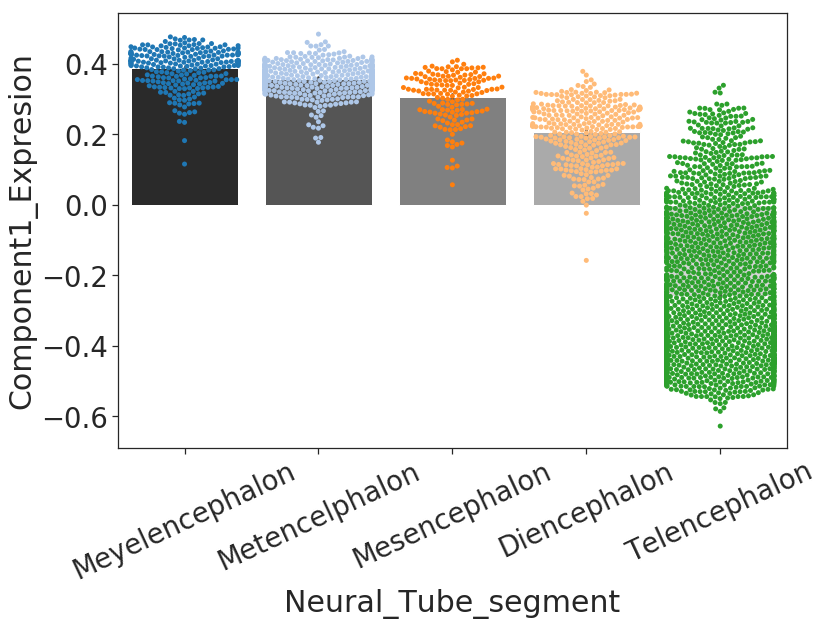

In [127]:
sns.set_context('notebook',font_scale=2.5)
plt.subplots(figsize=(12,8))
order = ['Meyelencephalon', 'Metencelphalon', 'Mesencephalon', 
         'Diencephalon', 'Telencephalon']
sns.barplot(x='Neural_Tube_segment', y='Component1_Expresion', 
            data=gdf,palette='gray',
           order = order)
g=sns.swarmplot(x='Neural_Tube_segment', y='Component1_Expresion', 
              data=gdf, 
              #hue='brain_divison',
              order = order, palette='tab20')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticklabels(order,rotation=25)
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/C1_NT.pdf',
#            bbox_inches='tight')

In [128]:
rbpal = [sns.color_palette('RdBu')[0],
                      sns.color_palette('RdBu')[-1]]

Text(0.5, 0, '')

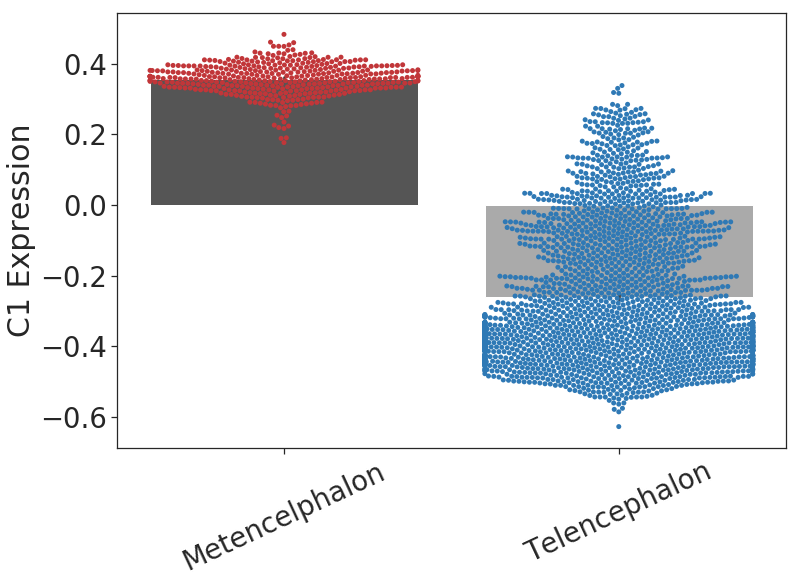

In [129]:
# Just cortex and cerebellum
sns.set_context('notebook',font_scale=2.5)
plt.subplots(figsize=(12,8))
order = ['Metencelphalon','Telencephalon']
sns.barplot(x='Neural_Tube_segment', y='Component1_Expresion', 
            data=gdf[gdf.Neural_Tube_segment.isin(order)],
            palette='gray',
           order = order
           )
g=sns.swarmplot(x='Neural_Tube_segment', y='Component1_Expresion', 
              data=gdf[gdf.Neural_Tube_segment.isin(order)], 
              #hue='brain_divison',
              order = order, palette=rbpal)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticklabels(order,rotation=25)
plt.ylabel('C1 Expression')
plt.xlabel('')
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/BSComp_ABA_C1.pdf',
#            bbox_inches='tight')

In [130]:
bsn = []
for x in gdf.structure_name.values:
    if ',' in x:
        bsn.append(x.split(',')[0])
    else:
        bsn.append(x)
gdf.loc[:,'bilateral_structure_name'] = bsn

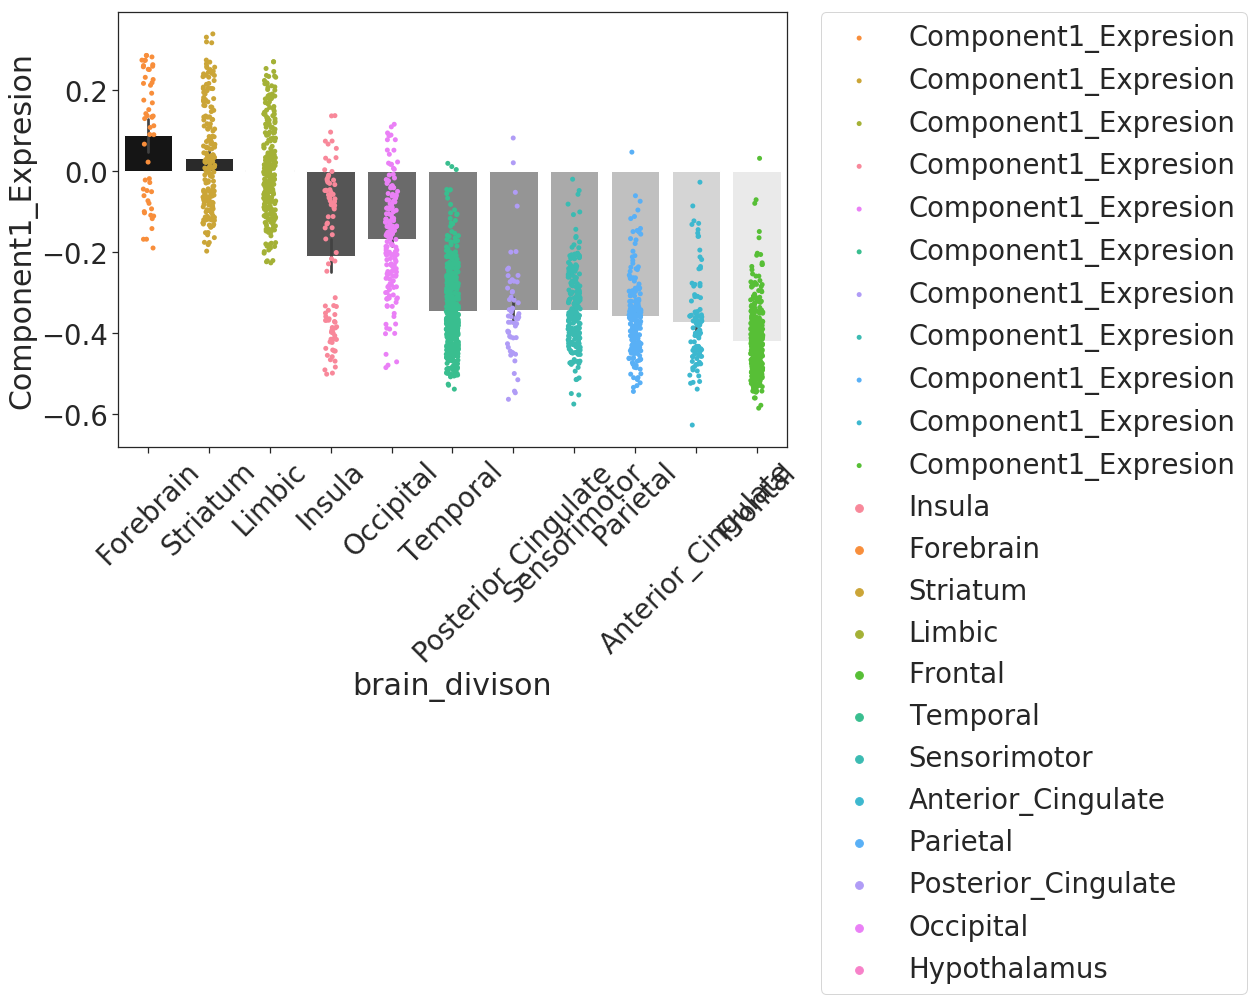

In [131]:
plt.subplots(figsize=(12,8))
order = ['Forebrain', 'Striatum', 'Limbic', 'Insula', 'Occipital',
        'Temporal','Posterior_Cingulate','Sensorimotor','Parietal',
        'Anterior_Cingulate','Frontal']
g=sns.barplot(x='brain_divison', y='Component1_Expresion', order = order,
            data=gdf[gdf.Neural_Tube_segment=='Telencephalon'], palette='gray',
           )
h=sns.stripplot(x='brain_divison', y='Component1_Expresion', order=order,jitter=True,
              hue='brain_divison',
            data=gdf[gdf.Neural_Tube_segment=='Telencephalon'],
           )
for item in h.get_xticklabels():
    item.set_rotation(45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ADDX/C1_Tele.pdf',
#            bbox_inches='tight')

In [132]:
gdf.Sensory_Type.value_counts()

Association_Cortex    1725
Not_Cortex            1354
Sensorimotor           215
Visual                 107
Auditory                60
Olfactory                3
Name: Sensory_Type, dtype: int64

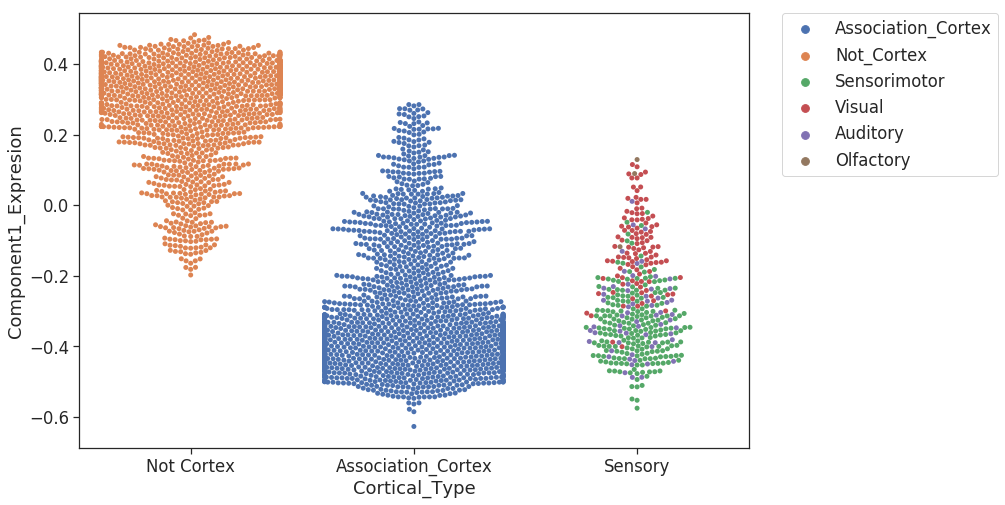

In [133]:
sns.set_context('notebook',font_scale=1.5)
plt.subplots(figsize=(12,8))
order = ['Not Cortex','Association_Cortex','Sensory']
sns.swarmplot(x='Cortical_Type', y='Component1_Expresion', data=gdf, hue='Sensory_Type', order=order)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ADDX/C1_Modals.pdf',
#            bbox_inches='tight')

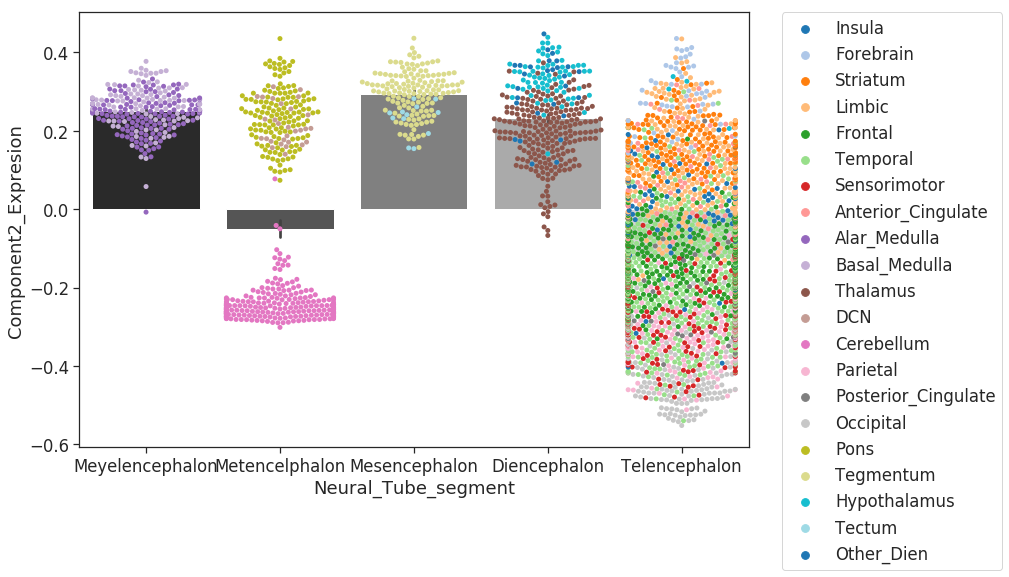

In [134]:
sns.set_context('notebook',font_scale=1.5)
plt.subplots(figsize=(12,8))
order = ['Meyelencephalon', 'Metencelphalon', 'Mesencephalon', 'Diencephalon', 'Telencephalon']
sns.barplot(x='Neural_Tube_segment', y='Component2_Expresion', data=gdf,palette='gray',
           order = order)
sns.swarmplot(x='Neural_Tube_segment', y='Component2_Expresion', data=gdf, hue='brain_divison',
              order = order, palette='tab20')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ADDX/C2_NT.pdf',
#            bbox_inches='tight')

[Text(0, 0, 'Meyelencephalon'),
 Text(0, 0, 'Metencelphalon'),
 Text(0, 0, 'Mesencephalon'),
 Text(0, 0, 'Diencephalon'),
 Text(0, 0, 'Telencephalon')]

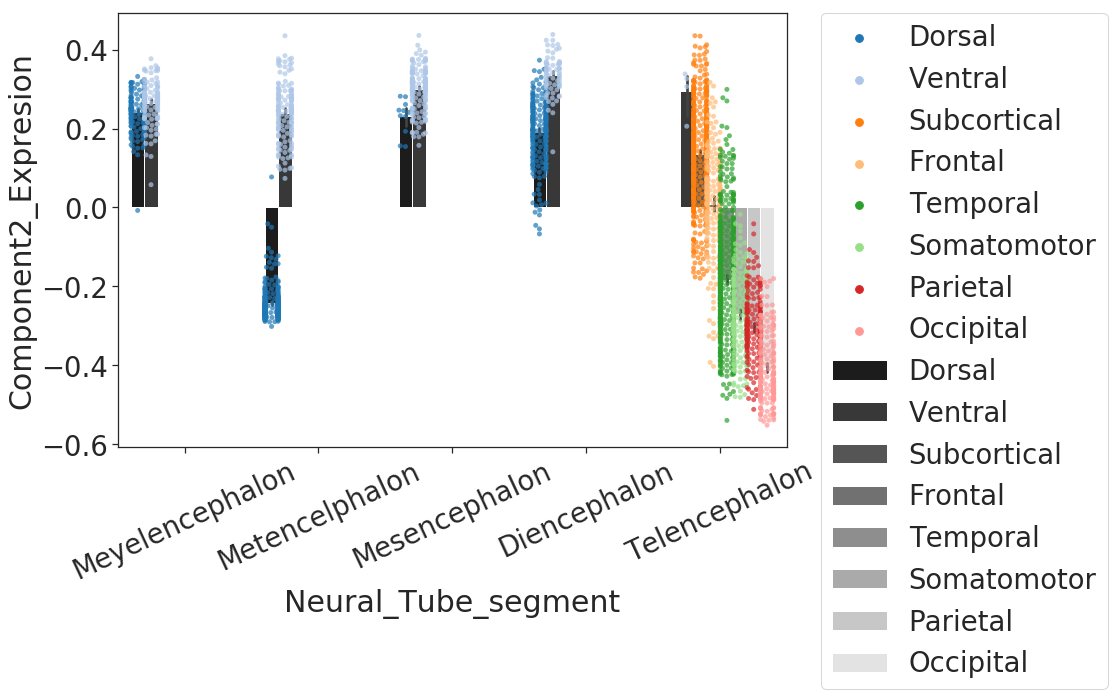

In [135]:
sns.set_context('notebook',font_scale=2.5)
plt.subplots(figsize=(12,8))
order = ['Meyelencephalon', 'Metencelphalon', 'Mesencephalon', 
         'Diencephalon','Telencephalon']
horder = ['Dorsal','Ventral','Subcortical','Frontal','Temporal',
         'Somatomotor','Parietal','Occipital']
sns.barplot(x='Neural_Tube_segment', y='Component2_Expresion', 
            data=gdf,palette='gray',hue='Neural_Plate',
           order = order,hue_order=horder)
g=sns.swarmplot(x='Neural_Tube_segment', y='Component2_Expresion', 
              data=gdf, hue='Neural_Plate',dodge=True,
              order = order, palette='tab20',hue_order=horder,
               alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticklabels(order,rotation=25)
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/C2_NT.pdf',
#            bbox_inches='tight')

[Text(0, 0, 'Meyelencephalon'),
 Text(0, 0, 'Metencelphalon'),
 Text(0, 0, 'Mesencephalon'),
 Text(0, 0, 'Diencephalon')]

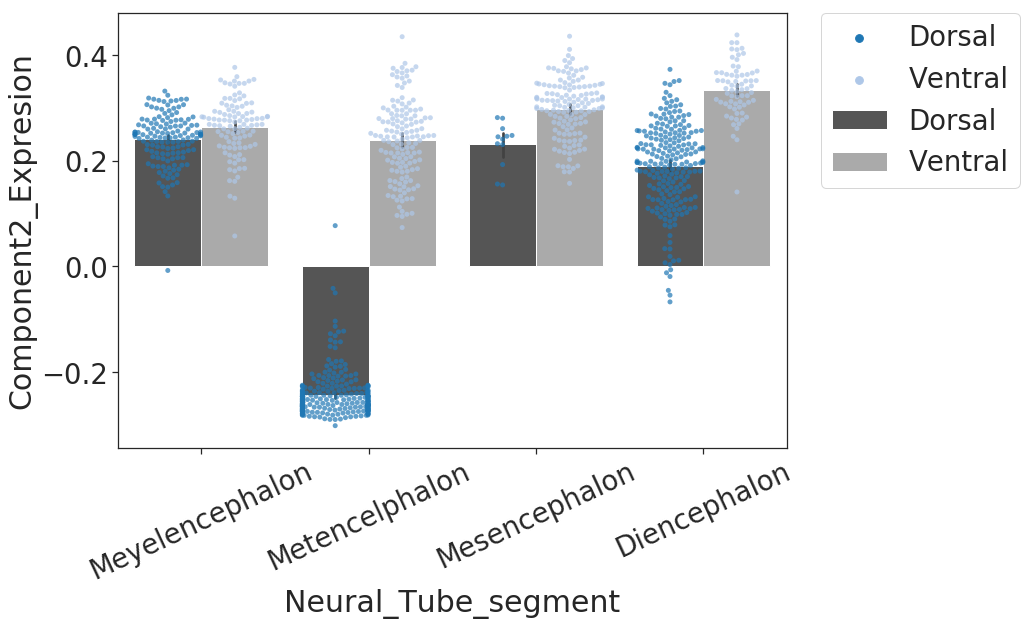

In [136]:
sns.set_context('notebook',font_scale=2.5)
plt.subplots(figsize=(12,8))
order = ['Meyelencephalon', 'Metencelphalon', 'Mesencephalon', 
         'Diencephalon']
horder = ['Dorsal','Ventral']
sns.barplot(x='Neural_Tube_segment', y='Component2_Expresion', 
            data=gdf[gdf.Neural_Tube_segment!='Telencephalon'],
            palette='gray',hue='Neural_Plate',
           order = order,hue_order=horder)
g=sns.swarmplot(x='Neural_Tube_segment', y='Component2_Expresion', 
              data=gdf[gdf.Neural_Tube_segment!='Telencephalon'],
                hue='Neural_Plate',dodge=True,
              order = order, palette='tab20',hue_order=horder,
               alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticklabels(order,rotation=25)
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/C2_NT-NoTele.pdf',
#            bbox_inches='tight')

Text(0.5, 0, 'Telencephalon')

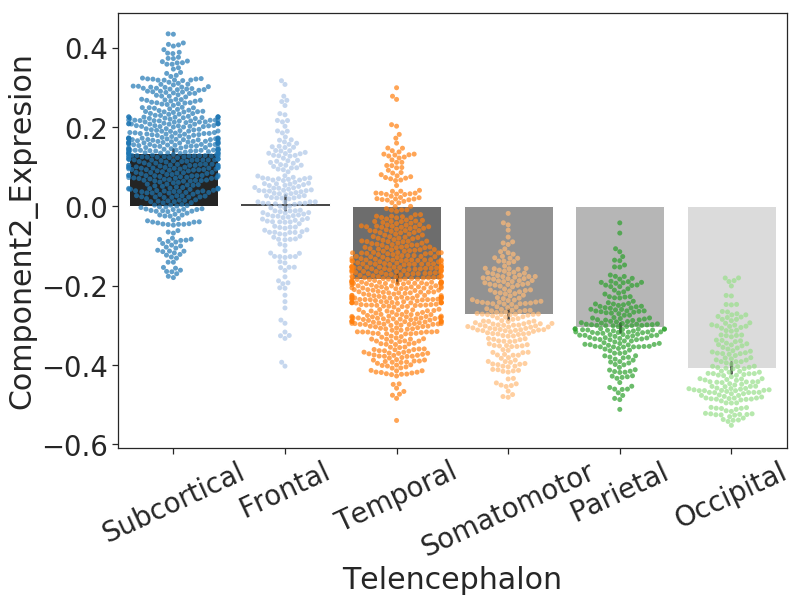

In [137]:
sns.set_context('notebook',font_scale=2.5)
plt.subplots(figsize=(12,8))
order = ['Subcortical', 'Frontal', 'Temporal','Somatomotor', 
         'Parietal','Occipital']
#horder = ['Dorsal','Ventral']
sns.barplot(x='Neural_Plate', y='Component2_Expresion', 
            data=gdf[gdf.Neural_Tube_segment=='Telencephalon'],
            palette='gray',#hue='Neural_Plate',
           order = order,
            hue_order=order
           )
g=sns.swarmplot(x='Neural_Plate', y='Component2_Expresion', 
              data=gdf[gdf.Neural_Tube_segment=='Telencephalon'],
                #hue='Neural_Plate',dodge=True,
              order = order, 
                #hue_order=order,
                palette='tab20',alpha=0.7)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticklabels(order,rotation=25)
plt.xlabel('Telencephalon')
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/C2_NT-TeleOnly.pdf',
#            bbox_inches='tight')

In [138]:
for i in range(1,4):
    c_vals = pandas.pivot_table(gdf,values='Component%s_Expresion'%i,
                                 index='brain_divison',aggfunc=np.mean
                                )
    for div in c_vals.index:
        sem = gdf[gdf.brain_divison==div]['Component%s_Expresion'%i
                                         ].sem()
        c_vals.loc[div,'sem'] = sem
    c_vals.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/GCorr_BSComp_ABA_C%s_data.csv'%i)
    c_vals.head()

In [139]:
c2_vals = pandas.pivot_table(gdf,values='Component2_Expresion',
                             index='brain_divison',aggfunc=np.mean
                            )
for div in c2_vals.index:
    sem = gdf[gdf.brain_divison==div]['Component2_Expresion'].sem()
    c2_vals.loc[div,'sem'] = sem
c2_vals.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/GCorr_BSComp_ABA_C2_data.csv')
c2_vals.head()

Component2_Expresion       sem
brain_divison                                     
Alar_Medulla                    0.241062  0.004061
Anterior_Cingulate              0.033473  0.013000
Basal_Medulla                   0.264733  0.005385
Cerebellum                     -0.243192  0.002716
DCN                             0.215339  0.009364

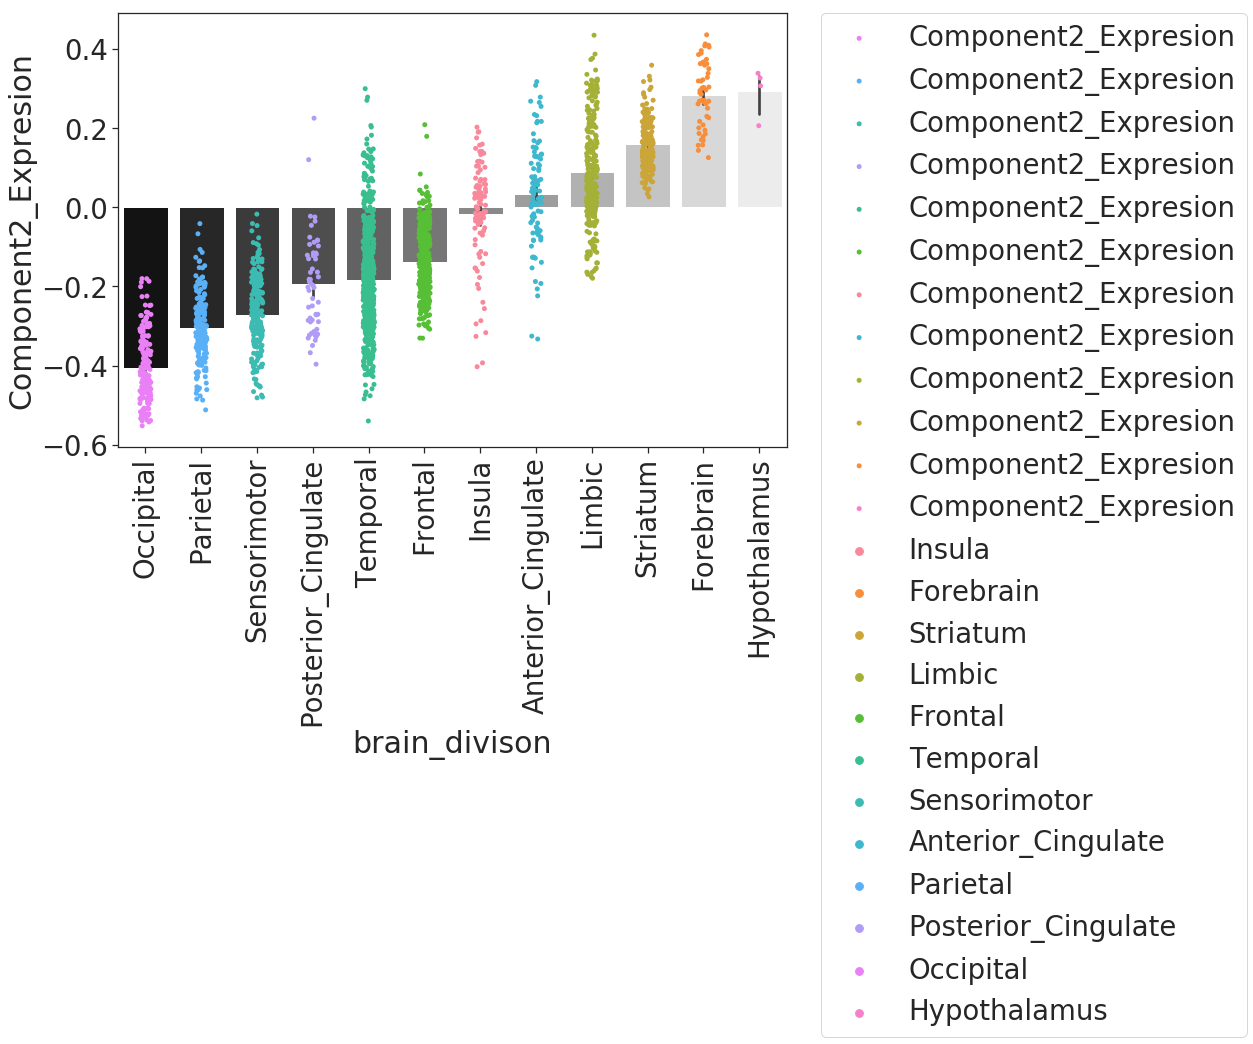

In [141]:
order = gdf[gdf.Neural_Tube_segment=='Telencephalon'
           ].pivot_table(values='Component2_Expresion',index = 'brain_divison'
                       ).sort_values('Component2_Expresion').index

plt.subplots(figsize=(12,8))
g=sns.barplot(x='brain_divison', y='Component2_Expresion', order = order,
            data=gdf[gdf.Neural_Tube_segment=='Telencephalon'], palette='gray',
           )
h=sns.stripplot(x='brain_divison', y='Component2_Expresion', order=order,jitter=True,
              hue='brain_divison',
            data=gdf[gdf.Neural_Tube_segment=='Telencephalon'],
           )
for item in h.get_xticklabels():
    item.set_rotation(90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ADDX/C2_Tele.pdf',
#            bbox_inches='tight')

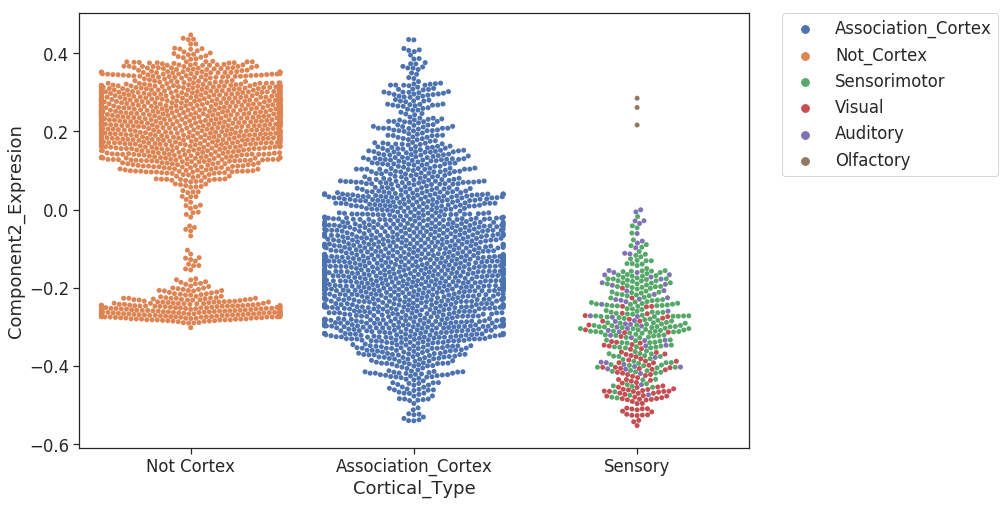

In [142]:
sns.set_context('notebook',font_scale=1.5)
plt.subplots(figsize=(12,8))
order = ['Not Cortex','Association_Cortex','Sensory']
sns.swarmplot(x='Cortical_Type', y='Component2_Expresion', data=gdf, hue='Sensory_Type', order=order)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ADDX/C2_Modals.pdf',
#            bbox_inches='tight')

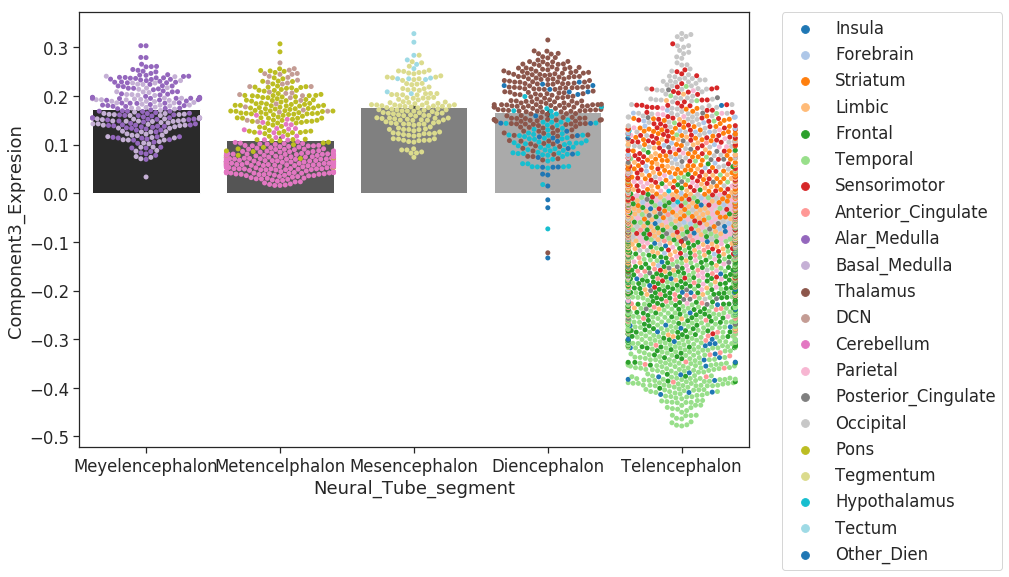

In [143]:
sns.set_context('notebook',font_scale=1.5)
plt.subplots(figsize=(12,8))
order = ['Meyelencephalon', 'Metencelphalon', 'Mesencephalon', 'Diencephalon', 'Telencephalon']
sns.barplot(x='Neural_Tube_segment', y='Component3_Expresion', data=gdf,palette='gray',
           order = order)
sns.swarmplot(x='Neural_Tube_segment', y='Component3_Expresion', data=gdf, hue='brain_divison',
              order = order, palette='tab20')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ADDX/C3_NT.pdf',
#            bbox_inches='tight')

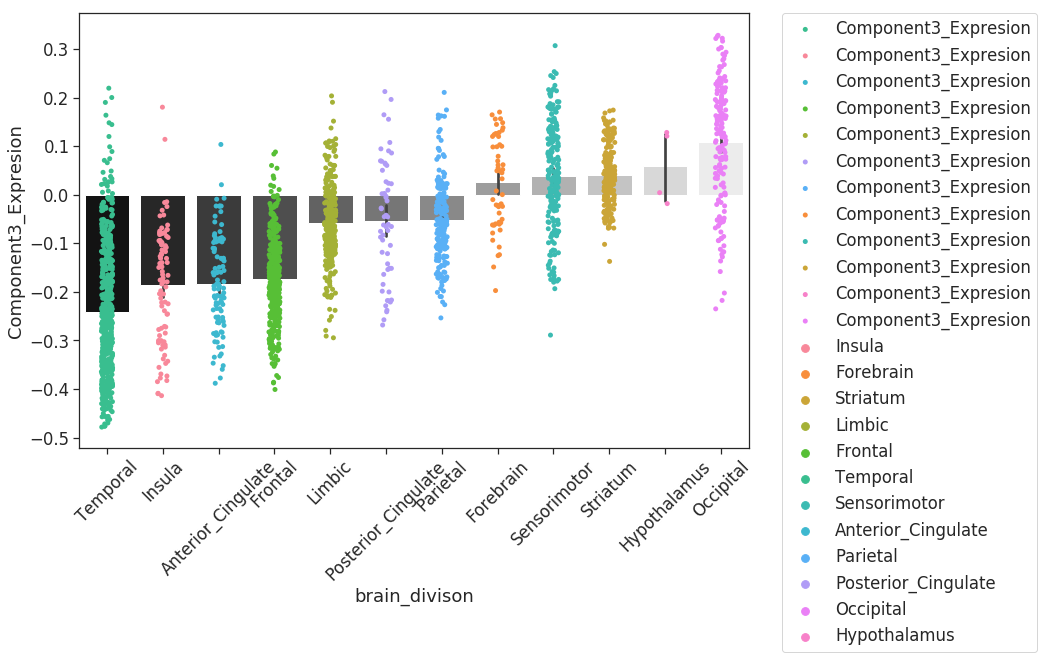

In [144]:
order = gdf[gdf.Neural_Tube_segment=='Telencephalon'
           ].pivot_table(values='Component3_Expresion',index = 'brain_divison'
                       ).sort_values('Component3_Expresion').index

plt.subplots(figsize=(12,8))
g=sns.barplot(x='brain_divison', y='Component3_Expresion', order = order,
            data=gdf[gdf.Neural_Tube_segment=='Telencephalon'], palette='gray',
           )
h=sns.stripplot(x='brain_divison', y='Component3_Expresion', order=order,jitter=True,
              hue='brain_divison',
            data=gdf[gdf.Neural_Tube_segment=='Telencephalon'],
           )
for item in h.get_xticklabels():
    item.set_rotation(45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ADDX/C3_Tele.pdf',
#            bbox_inches='tight')

In [260]:
gdf.columns[-10:]

Index(['new_structure_acronym', 'abs_mni_nlin_x', 'brain_divison',
       'Neural_Tube_segment', 'Sensory_Type', 'Cortical_Type',
       'Component1_Expresion', 'Component2_Expresion', 'Component3_Expresion',
       'bilateral_structure_name'],
      dtype='object')

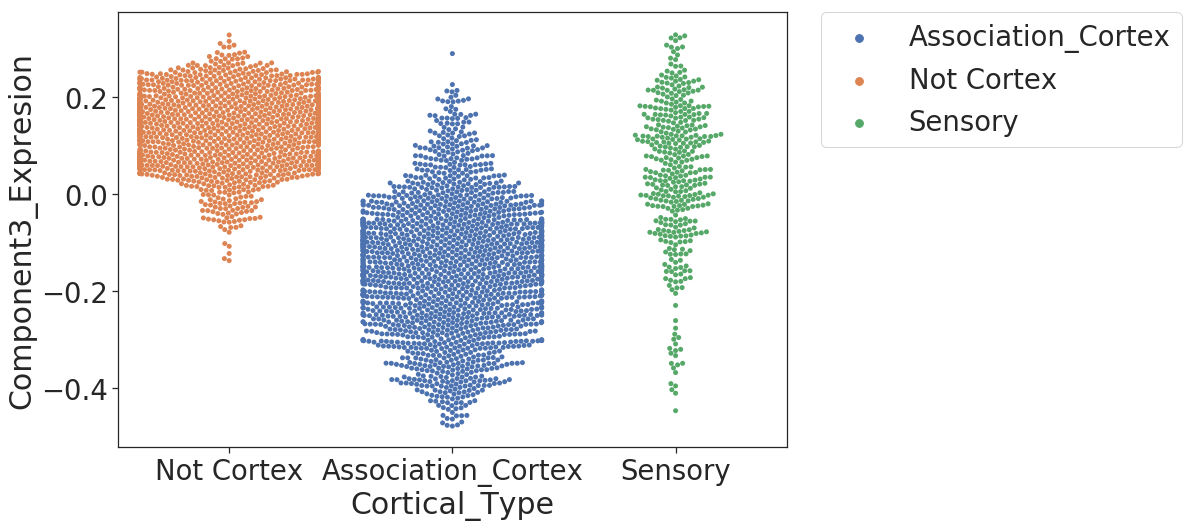

In [145]:
sns.set_context('notebook',font_scale=2.5)
plt.subplots(figsize=(12,8))
order = ['Not Cortex','Association_Cortex','Sensory']
sns.swarmplot(x='Cortical_Type', y='Component3_Expresion', 
              data=gdf, hue='Cortical_Type',order=order,
             )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/C3_Modals.pdf',
#            bbox_inches='tight')

In [355]:
for col in gdf.columns[-4:-1]:
    

Index(['Component1_Expresion', 'Component2_Expresion', 'Component3_Expresion'], dtype='object')

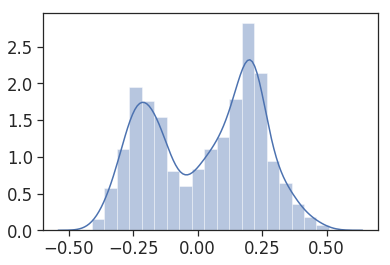

In [133]:
sns.distplot(c2_xp)

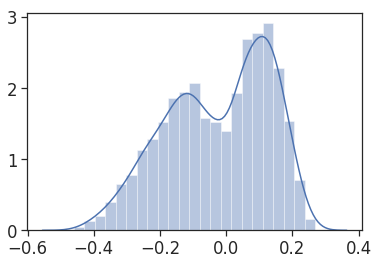

In [134]:
sns.distplot(c3_xp)

# Projection

In [147]:
pcamod = PCA(n_components=100, random_state=123).fit(bigdf)
sum(pcamod.explained_variance_ratio_)
pca_tfm = pandas.DataFrame(pcamod.transform(bigdf))
pls_mod = PLSRegression(n_components=3)
#full_y = gdf[['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
pls_mod.fit(pca_tfm, full_y)

PLSRegression(copy=True, max_iter=500, n_components=3, scale=True, tol=1e-06)

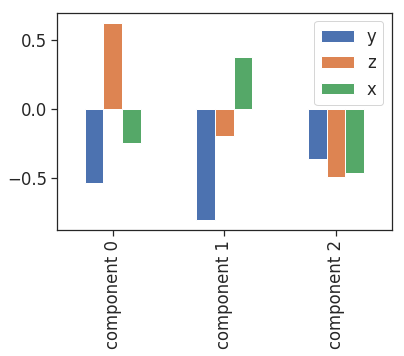

In [156]:
sns.set_context('notebook',font_scale=1.5)
pandas.DataFrame(pls_mod.y_weights_, 
                 index=['component %s'%x for x in range(3)],
                 columns=['y','z','x']).plot.bar()

In [149]:
pls_mod.y_weights_[0]

array([-0.53740344,  0.62235325, -0.25007202])

In [150]:
pls_mod.y_weights_[0,:]

array([-0.53740344,  0.62235325, -0.25007202])

In [151]:
input_coords = []
for i,row in gdf.iterrows():
    input_coords.append(hap.convert_coords([round(int(row['mni_nlin_x'])), 
                                        round(int(row['mni_nlin_y'])), 
                                        round(int(row['mni_nlin_z']))], 'xyz'))
nm = 'NEUR608_IMG_c2'
mni_pth = '/home/users/jvogel/Science/templates/templates/MNI152_T1_1mm_brain.nii'
wdir = '/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ADDX/'
gcx_img = hap.make_expression_image(c2_xp, input_coords, mni_pth, wdir, nm, 5, return_img=True)

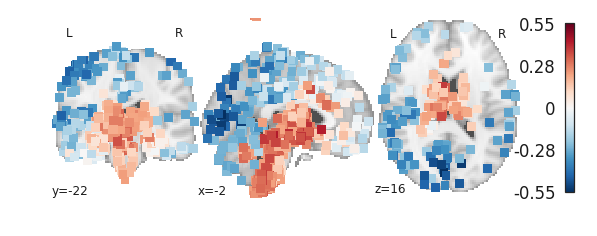

In [157]:
plotting.plot_stat_map(gcx_img,cut_coords=[-2,-22,16],
                       cmap='RdBu_r',
                       draw_cross=False)
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/C2_BrainGxp.pdf',
#             bbox_inches='tight')

In [ ]:
#gcx_img.to_filename('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/C2_XWeights.nii.gz')

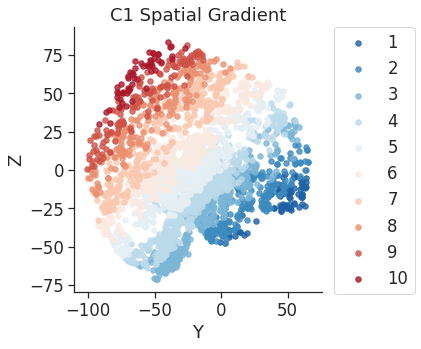

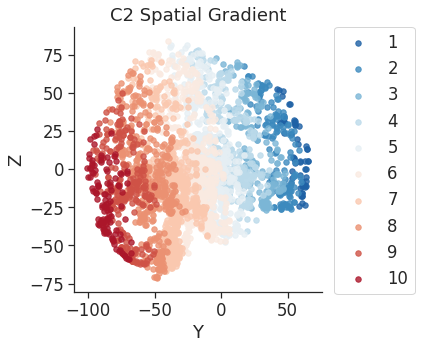

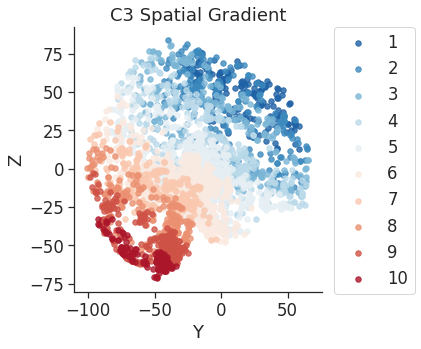

In [158]:
from sklearn.preprocessing import MinMaxScaler

for i in range(pls_mod.y_weights_.shape[0]):
    sg = np.dot(full_y.values,pls_mod.y_weights_[i,:])
    gdf.loc[:,'C%s_SmoothGradient'%(i+1)] = sg
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    cut = pandas.cut(scaled_sg,10)
    code = dict(zip(np.unique(cut),range(1,len(np.unique(cut))+1)))
    gdf.loc[:,'C%s_SpatialGradient'%(i+1)] = [code[x] for x in cut]

    sns.lmplot('mni_nlin_y', 'mni_nlin_z', 
               hue = 'C%s_SpatialGradient'%(i+1),legend=False, 
               data=gdf, fit_reg=False, 
               scatter_kws={"s": 30},
              palette='RdBu_r')
    plt.xlabel('Y')
    plt.ylabel('Z')
    plt.title('C%s Spatial Gradient'%(i+1))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    #plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/C%s_BrainSpatialWB.pdf'%(i+1),
    #       bbox_inches='tight')
    plt.show()
    
#     gcx_img = hap.make_expression_image(#gdf['C%s_SpatialGradient'%(i+1)
#                                         #   ].values - 5.1,
#                                         sg,
#                                         input_coords, mni_pth, wdir, 
#                                         nm, 5, return_img=True)
#     plotting.plot_stat_map(gcx_img,cut_coords=[-2,-22,16],
#                        cmap='RdBu_r',
#                        draw_cross=False)
    
#     plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/C%s_BrainSpatial.pdf'%(i+1),
#                bbox_inches='tight')
#     plt.show()
#     gcx_img.to_filename('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/C%s_YWeights.nii.gz'%(i+1))

(-81, 95)

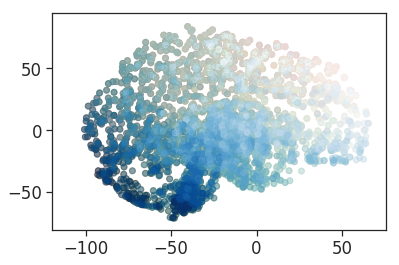

In [159]:
plt.scatter(gdf.mni_nlin_y.values,gdf.mni_nlin_z.values,
           c = gdf.C1_SpatialGradient.values,cmap='Reds',
           alpha=0.3)
plt.scatter(gdf.mni_nlin_y.values,gdf.mni_nlin_z.values,
           c = gdf.C2_SpatialGradient.values,cmap='Greens',
           alpha=0.3)
plt.scatter(gdf.mni_nlin_y.values,gdf.mni_nlin_z.values,
           c = gdf.C3_SpatialGradient.values,cmap='Blues',
           alpha=0.3)
plt.xlim(-120,76)
plt.ylim(-81,95)

In [160]:
code = dict(zip(range(1,11),
               [1,1,1,2,2,2,2,3,3,3]))
conversion = []
for i,row in gdf.iterrows():
    conversion.append('%s%s%s'%(code[row['C1_SpatialGradient']],
                          code[row['C2_SpatialGradient']],
                          code[row['C3_SpatialGradient']]))
code = dict(zip(np.unique(conversion),
               range(1,len(np.unique(conversion))+1)))
gdf.loc[:,'GradExp_Gp'] = [code[x] for x in conversion]

In [161]:
code

{'111': 1,
 '112': 2,
 '121': 3,
 '122': 4,
 '123': 5,
 '132': 6,
 '133': 7,
 '211': 8,
 '212': 9,
 '221': 10,
 '222': 11,
 '223': 12,
 '231': 13,
 '232': 14,
 '233': 15,
 '311': 16,
 '321': 17,
 '322': 18,
 '331': 19,
 '332': 20,
 '333': 21}

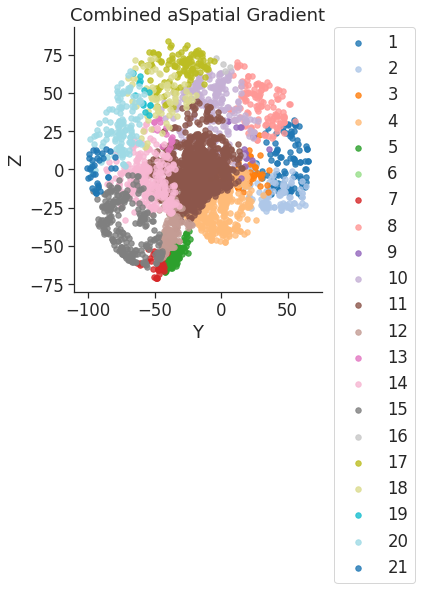

In [162]:
sns.set_context('notebook',font_scale=1.5)
sns.lmplot('mni_nlin_y', 'mni_nlin_z', 
               hue = 'GradExp_Gp',legend=False, 
               data=gdf, fit_reg=False, 
               scatter_kws={"s": 30},
              palette='tab20')
plt.xlabel('Y')
plt.ylabel('Z')
plt.title('Combined aSpatial Gradient')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

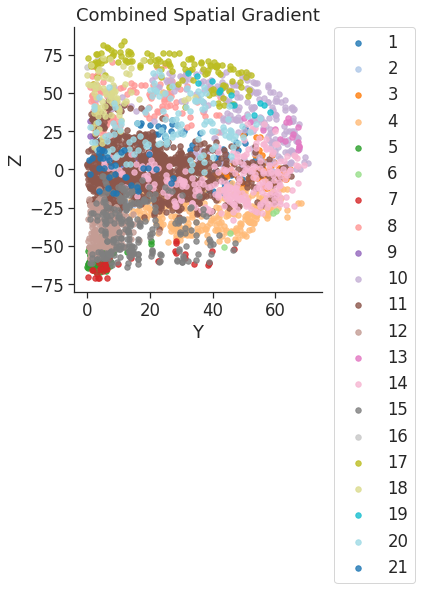

In [163]:
sns.lmplot('abs_mni_nlin_x', 'mni_nlin_z', 
               hue = 'GradExp_Gp',legend=False, 
               data=gdf, fit_reg=False, 
               scatter_kws={"s": 30},
              palette='tab20')
plt.xlabel('Y')
plt.ylabel('Z')
plt.title('Combined Spatial Gradient')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [173]:
gdf.Neural_Tube_segment.unique()

array(['Telencephalon', 'Meyelencephalon', 'Diencephalon',
       'Metencelphalon', 'Mesencephalon', nan], dtype=object)

In [184]:
pandas.crosstab(index=gdf[gdf.Neural_Tube_segment=='Telencephalon'].GradExp_Gp,
                columns=gdf[gdf.Neural_Tube_segment=='Telencephalon'].brain_divison)

brain_divison  Anterior_Cingulate  Forebrain  Frontal  Hypothalamus  Insula  \
GradExp_Gp                                                                    
1                               5          0      104             0       2   
2                              20          1       80             0       0   
3                               0          0       35             0       7   
4                               3         23       16             0      17   
6                               0          0        0             0       0   
8                              33          1       99             0       0   
9                               9          0        0             0       0   
10                              7          0       63             0       7   
11                             21         27        0             4      57   
13                              0          0        0             0       0   
14                              0          0        0             0       1   
15                              0          0        0             0       0   
16                              0          0        3             0       0   
17                              0          0        1             0       0   
18                              1          0        0             0       0   
19                              0          0        0             0       0   
20                              0          0        0             0       0   
21                              0          0        0             0       0   

brain_divison  Limbic  Occipital  Parietal  Posterior_Cingulate  Sensorimotor  \
GradExp_Gp                                                                      
1                   0          0         0                    0             0   
2                   1          0         0                    0             0   
3                   0          0         0                    0             1   
4                  32          0         0                    0             0   
6                   0          0         0                    0             0   
8                   0          0         0                    0             0   
9                   0          0         0                    0             0   
10                  0          0        29                    2           109   
11                236          6         2                   31             3   
13                  0          0         5                    0             0   
14                  0         56         5                    1             0   
15                  0         16         0                    0             0   
16                  0          0         0                    0             1   
17                  0          0        31                    0            89   
18                  0          1        40                   22            12   
19                  0          0        13                    0             0   
20                  0         57        68                    1             0   
21                  0         34         0                    0             0   

brain_divison  Striatum  Temporal  
GradExp_Gp                         
1                     0         0  
2                     7         0  
3                     0        28  
4                    13       205  
6                     0         2  
8                     0         0  
9                     8         0  
10                    1        26  
11                  168       108  
13                    0        11  
14                    0       177  
15                    0         6  
16                    0         0  
17                    0         0  
18                    0         0  
19                    0         0  
20                    0         5  
21                    0         0

In [192]:
gdf[gdf.GradExp_Gp==19]['brain_divison'].value_counts()

Parietal    13
Name: brain_divison, dtype: int64

1: (Frontal)
2: (ACC), (Frontal)
3: ((Frontal)), ((Temporal))
4: (Forebrain),(Temporal)
5: Medulla
6: 
7: ((Cerebellum)),((Medulla))
8: (ACC), (Frontal)
9:
10: (Frontal),(Sensorimorot)
11: Midbrain, Thalamus, Hypothalamus, Other_Dien, Insula, Limbic, Striatum, (ACC), (Forebrain),(PCC),(Temporal)
12: Medulla, Pons
13:
14: (Occipital),(Temporal)
15: Cerebellum
16:
17: (Sensorimotor)
18: (Parietal),(PCC)
19: ((Parietal))
20: (Occipital),(Parietal)
21: (Occipital)

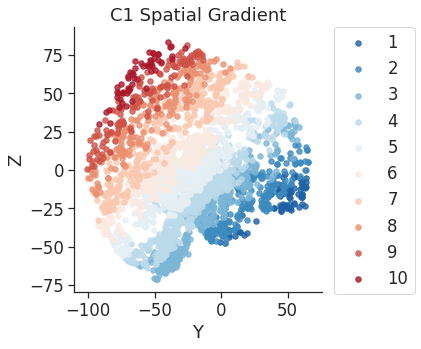

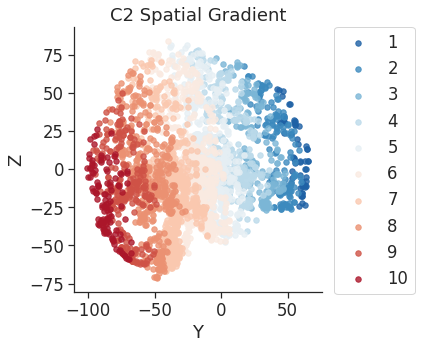

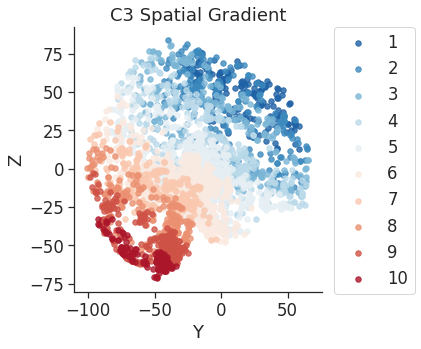

In [164]:
for i in range(pls_mod.y_weights_.shape[0]):
    sg = np.dot(full_y.values,pls_mod.y_weights_[i,:])
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    cut = pandas.cut(scaled_sg,10)
    code = dict(zip(np.unique(cut),range(1,len(np.unique(cut))+1)))
    gdf.loc[:,'C%s_SpatialGradient'%(i+1)] = [code[x] for x in cut]

    sns.lmplot('mni_nlin_y', 'mni_nlin_z', 
               hue = 'C%s_SpatialGradient'%(i+1),legend=False, 
               data=gdf, fit_reg=False, 
               scatter_kws={"s": 30},
              palette='RdBu_r')
    plt.xlabel('Y')
    plt.ylabel('Z')
    plt.title('C%s Spatial Gradient'%(i+1))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/C%s_BrainSpatialWB.pdf'%(i+1),
#            bbox_inches='tight')
    plt.show()

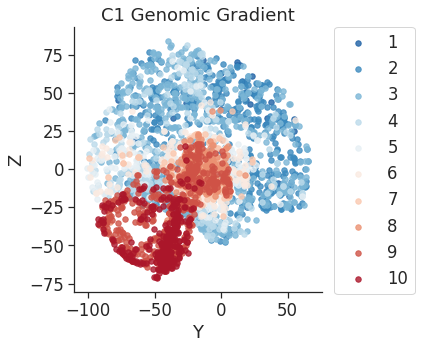

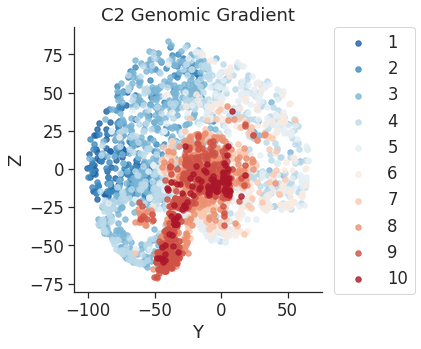

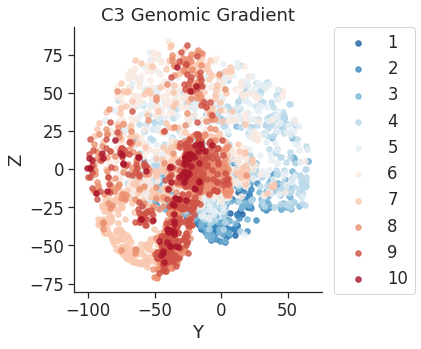

In [169]:
for i in range(pls_mod.y_weights_.shape[0]):
    sg = gdf.loc[:,'Component%s_Expresion'%(i+1)].values
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    cut = pandas.cut(scaled_sg,10)
    code = dict(zip(np.unique(cut),range(1,len(np.unique(cut))+1)))
    gdf.loc[:,'C%s_GCut'%(i+1)] = [code[x] for x in cut]

    sns.lmplot('mni_nlin_y', 'mni_nlin_z', 
               hue = 'C%s_GCut'%(i+1),legend=False, 
               data=gdf, fit_reg=False, 
               scatter_kws={"s": 30},
              palette='RdBu_r')
    plt.xlabel('Y')
    plt.ylabel('Z')
    plt.title('C%s Genomic Gradient'%(i+1))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

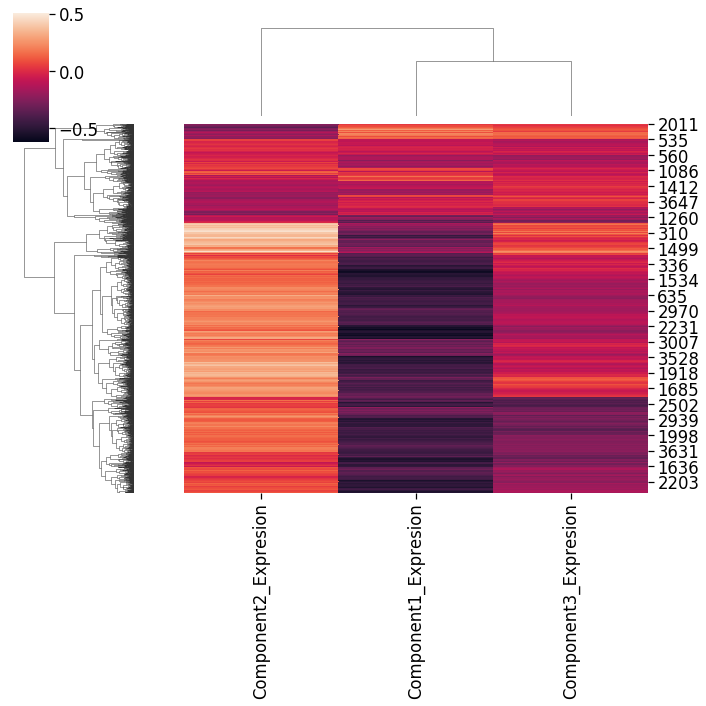

In [30]:
sns.clustermap(gdf[gdf.Neural_Tube_segment=='Telencephalon'
                  ][['Component1_Expresion',
                   'Component2_Expresion',
                   'Component3_Expresion']])